#***Unsupervised Learning - Alice Menna (888564) and Federica Tonoli (898661)***

# LIBRARIES

In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial.distance import pdist, squareform
from scipy.stats import chi2_contingency
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA LOADING

In [ ]:
# Load the dataset
filePath = "/content/drive/MyDrive/UnsupervisedLearning/mehra-complete-1000.csv"
df = pd.read_csv(filePath)
[N,M] = np.shape(df)    # N=no. of objects, M=no. of attributes

# Dataset basic information
print("The matrix has shape =", np.shape(df))
print('It has %d objects and %d attributes.' % (N, M) )
print(f"Number of missing values: {df.isnull().sum().sum()}")

The matrix has shape = (1000, 24)
It has 1000 objects and 24 attributes.
Number of missing values: 0


In [ ]:
# Display basic statistics
print("First few rows:")
print(df.head())

First few rows:
                     Region                           Zone              Type  \
0             East Midlands                       Tyneside     Traffic Urban   
1             East Midlands  Greater Manchester Urban Area  Background Urban   
2                North West      Greater London Urban Area  Background Urban   
3           East of England             Kingston upon Hull     Traffic Urban   
4  Yorkshire and The Humber            Teesside Urban Area  Background Urban   

   Year  Season  Month  Day  Hour   Latitude  Longitude  ...        tp  \
0  1990  Spring      1    3    21  55.176035  -0.873855  ...  0.000062   
1  1994  Spring      9   14    23  53.059499  -1.520419  ...  0.002246   
2  1995  Winter      8   22    20  53.584375  -3.290433  ... -0.000639   
3  1987  Summer      7   26    13  52.886563  -3.635391  ...  0.000896   
4  1985  Spring      3   13    12  51.273065  -2.760794  ... -0.000268   

           blh           ssr     CVD60         no2        

In [ ]:
print("Dataset info:")
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Region     1000 non-null   object 
 1   Zone       1000 non-null   object 
 2   Type       1000 non-null   object 
 3   Year       1000 non-null   int64  
 4   Season     1000 non-null   object 
 5   Month      1000 non-null   int64  
 6   Day        1000 non-null   int64  
 7   Hour       1000 non-null   int64  
 8   Latitude   1000 non-null   float64
 9   Longitude  1000 non-null   float64
 10  Altitude   1000 non-null   float64
 11  t2m        1000 non-null   float64
 12  ws         1000 non-null   float64
 13  wd         1000 non-null   float64
 14  tp         1000 non-null   float64
 15  blh        1000 non-null   float64
 16  ssr        1000 non-null   float64
 17  CVD60      1000 non-null   float64
 18  no2        1000 non-null   float64
 19  o3         1000 non-null   float64


In [ ]:
# Analyze unique values per column
print("Unique values per column:")
for col in df.columns:
    uniqueCount = df[col].nunique()
    print(f"{col}: {uniqueCount} unique values")
    if uniqueCount <= 10:  # Show values for categorical variables
        print(f"  Values: {sorted(df[col].unique())}")

Unique values per column:
Region: 9 unique values
  Values: ['East Midlands', 'East of England', 'Greater London Authority', 'North East', 'North West', 'South East', 'South West', 'West Midlands', 'Yorkshire and The Humber']
Zone: 31 unique values
Type: 6 unique values
  Values: ['Background Rural', 'Background Suburban', 'Background Urban', 'Industrial Suburban', 'Industrial Urban', 'Traffic Urban']
Year: 20 unique values
Season: 4 unique values
  Values: ['Fall', 'Spring', 'Summer', 'Winter']
Month: 12 unique values
Day: 31 unique values
Hour: 24 unique values
Latitude: 1000 unique values
Longitude: 1000 unique values
Altitude: 1000 unique values
t2m: 1000 unique values
ws: 1000 unique values
wd: 1000 unique values
tp: 1000 unique values
blh: 1000 unique values
ssr: 1000 unique values
CVD60: 1000 unique values
no2: 1000 unique values
o3: 1000 unique values
so2: 1000 unique values
co: 1000 unique values
pm10: 1000 unique values
pm2.5: 1000 unique values


In [ ]:
# Define a palette of colours for the K clusters
PAL = ['black', 'red', 'green', 'blue', 'yellow', 'orange', 'purple', 'magenta', 'cyan', 'brown']

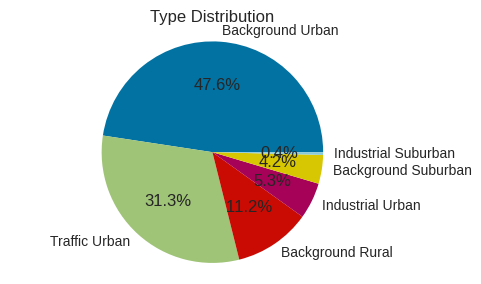

In [ ]:
# Plot Type distribution
valueCounts = df['Type'].value_counts()

plt.figure(figsize=(5, 3))
plt.pie(valueCounts.values, labels=valueCounts.index, autopct='%1.1f%%')
plt.title('Type Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

# DATA PREPROCESSING

In [ ]:
# Store the original Type column for later analysis
originalType = df['Type'].copy()

In [ ]:
# Separate numerical and categorical columns
numericalCols = df.select_dtypes(include=[np.number]).columns.tolist()
categoricalCols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns ({len(numericalCols)}): {numericalCols}")
print(f"Categorical columns ({len(categoricalCols)}): {categoricalCols}")

Numerical columns (20): ['Year', 'Month', 'Day', 'Hour', 'Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh', 'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']
Categorical columns (4): ['Region', 'Zone', 'Type', 'Season']


In [ ]:
# Do not consider Month, Hour, Day as numerical columns (they will be encoded cyclically)
excludeCols = ['Month', 'Hour', 'Day']
numericalCols = [col for col in numericalCols if col not in excludeCols]
print(f"Numerical columns after exclusion ({len(numericalCols)}): {numericalCols}")

Numerical columns after exclusion (17): ['Year', 'Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh', 'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']


In [ ]:
dfProcessed = df.copy()

In [ ]:
# Delete Type column as it is the variable we want to predict
for col in ['Type']:
    if col in dfProcessed.columns:
        dfProcessed = dfProcessed.drop(columns=[col])
        print(f"Dropped column: {col}")

Dropped column: Type


In [ ]:
# Delete Day column as it does not influence our statistic
for col in ['Day']:
    if col in dfProcessed.columns:
        dfProcessed = dfProcessed.drop(columns=[col])
        print(f"Dropped column: {col}")

Dropped column: Day


In [ ]:
# Encode Month and Hour using cyclical encoding
cyclicCols = ['Month', 'Hour']
for col in cyclicCols:
    maxVal = dfProcessed[col].max()
    dfProcessed[f"{col}_sin"] = np.sin(2 * np.pi * dfProcessed[col] / maxVal)
    dfProcessed[f"{col}_cos"] = np.cos(2 * np.pi * dfProcessed[col] / maxVal)
    dfProcessed = dfProcessed.drop(columns=[col])
    print(f"Applied cyclic encoding to '{col}'")

Applied cyclic encoding to 'Month'
Applied cyclic encoding to 'Hour'


## Encode categorical variables

In [ ]:
# Encode Zone variable (categorical) using Label Encoding
labelEncoders = {}
if 'Zone' in dfProcessed.columns:
    le = LabelEncoder()
    dfProcessed['Zone'] = le.fit_transform(dfProcessed['Zone'])
    labelEncoders['Zone'] = le
    print(f"Label Encoded 'Zone': {dict(zip(le.classes_, le.transform(le.classes_)))}")

Label Encoded 'Zone': {'Birkenhead Urban Area': np.int64(0), 'Blackpool Urban Area': np.int64(1), 'Bournemouth Urban Area': np.int64(2), 'Brighton/Worthing/Littlehampton': np.int64(3), 'Bristol Urban Area': np.int64(4), 'Coventry/Bedworth': np.int64(5), 'East Midlands': np.int64(6), 'Eastern': np.int64(7), 'Greater London Urban Area': np.int64(8), 'Greater Manchester Urban Area': np.int64(9), 'Kingston upon Hull': np.int64(10), 'Leicester Urban Area': np.int64(11), 'Liverpool Urban Area': np.int64(12), 'North East': np.int64(13), 'North West & Merseyside': np.int64(14), 'Nottingham Urban Area': np.int64(15), 'Portsmouth Urban Area': np.int64(16), 'Preston Urban Area': np.int64(17), 'Reading/Wokingham Urban Area': np.int64(18), 'Sheffield Urban Area': np.int64(19), 'South East': np.int64(20), 'South West': np.int64(21), 'Southampton Urban Area': np.int64(22), 'Southend Urban Area': np.int64(23), 'Teesside Urban Area': np.int64(24), 'The Potteries': np.int64(25), 'Tyneside': np.int64(26)

In [ ]:
# Encode Season and Region variables (categorical) using One-Hot Encoding
oneHotCols = ['Season', 'Region']
dfProcessed = pd.get_dummies(dfProcessed, columns=oneHotCols, prefix=oneHotCols)
print(f"One-Hot Encoded columns: {oneHotCols}")

One-Hot Encoded columns: ['Season', 'Region']


## Normalize numerical variables

In [ ]:
# Separate columns for different normalization strategies
# Update numerical columns after cyclic encoding
cyclicEncodedCols = ['Month_sin', 'Month_cos', 'Hour_sin', 'Hour_cos']
updatedNumericalCols = numericalCols + cyclicEncodedCols

# Get boolean columns (one-hot encoded)
booleanCols = [col for col in dfProcessed.columns if dfProcessed[col].dtype == bool]
print(f"Boolean columns (one-hot encoded): {booleanCols}")

Boolean columns (one-hot encoded): ['Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Region_East Midlands', 'Region_East of England', 'Region_Greater London Authority', 'Region_North East', 'Region_North West', 'Region_South East', 'Region_South West', 'Region_West Midlands', 'Region_Yorkshire and The Humber']


In [ ]:
# Create normalized dataset
dfNormalized = dfProcessed.copy()

# Apply StandardScaler only to numerical columns (not boolean ones)
scaler = StandardScaler()
dfNormalized[updatedNumericalCols] = scaler.fit_transform(dfProcessed[updatedNumericalCols])

# Convert boolean columns to int (0,1) for clustering algorithms
dfNormalized[booleanCols] = dfNormalized[booleanCols].astype(int)

print("Basic statistics for normalized numerical columns:")
print(dfNormalized[updatedNumericalCols].describe())

Basic statistics for normalized numerical columns:
               Year      Latitude     Longitude      Altitude           t2m  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean   3.232969e-15 -2.540190e-15  7.638334e-17 -8.881784e-19 -8.085976e-15   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -1.739351e+00 -2.965964e+00 -3.106101e+00 -3.151336e+00 -3.523063e+00   
25%   -8.492022e-01 -6.711813e-01 -6.149594e-01 -6.791273e-01 -6.910660e-01   
50%    4.094686e-02 -5.360936e-03  1.417225e-02 -2.435246e-02  4.440651e-02   
75%    9.310959e-01  6.734127e-01  6.366591e-01  6.796609e-01  6.931044e-01   
max    1.643215e+00  3.642547e+00  3.376023e+00  3.231302e+00  2.834108e+00   

                 ws            wd            tp           blh           ssr  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean  -7.815970e-17  2.842171e-16  7.105427e-18 -1.030287e-16  2.309264e-17   


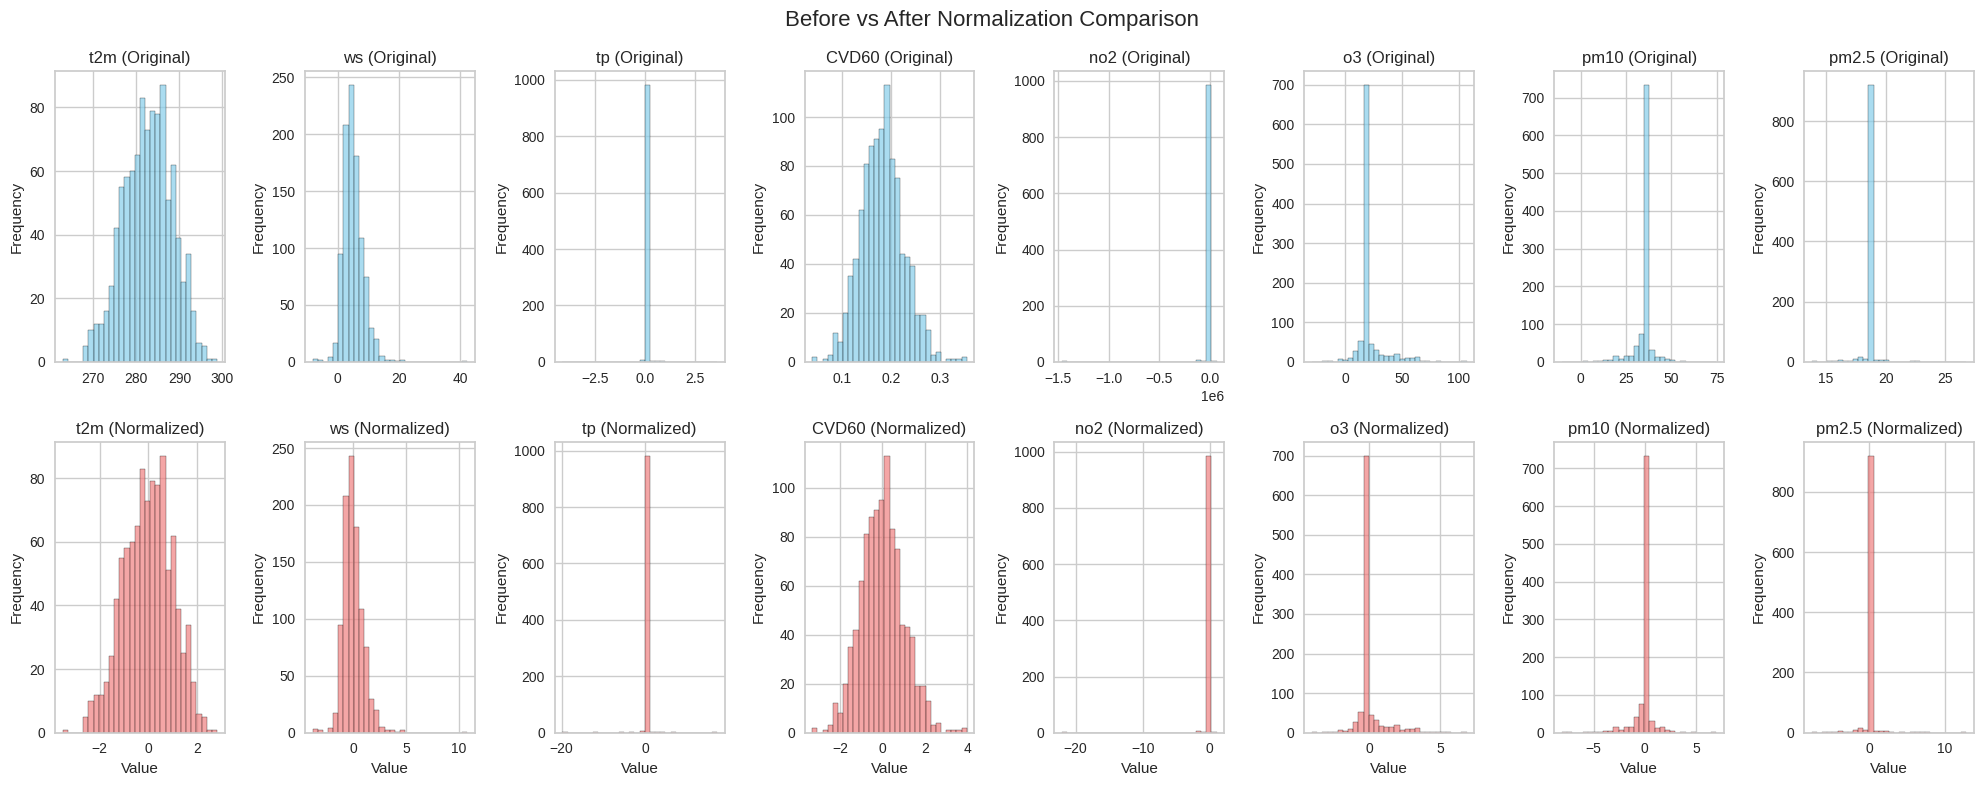

In [ ]:
# Plot selected numerical variables before and after normalization
selectedCols = ['t2m', 'ws', 'tp', 'CVD60', 'no2', 'o3', 'pm10', 'pm2.5']
selectedCols = [col for col in selectedCols if col in updatedNumericalCols]

if len(selectedCols) > 0:
    fig, axes = plt.subplots(2, len(selectedCols), figsize=(20, 8))
    fig.suptitle('Before vs After Normalization Comparison', fontsize=16)

    for i, col in enumerate(selectedCols):
        # Before normalization
        axes[0, i].hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, i].set_title(f'{col} (Original)')
        axes[0, i].set_ylabel('Frequency')

        # After normalization
        axes[1, i].hist(dfNormalized[col], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1, i].set_title(f'{col} (Normalized)')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_xlabel('Value')

    plt.tight_layout()
    plt.show()

## Visualize the dataset

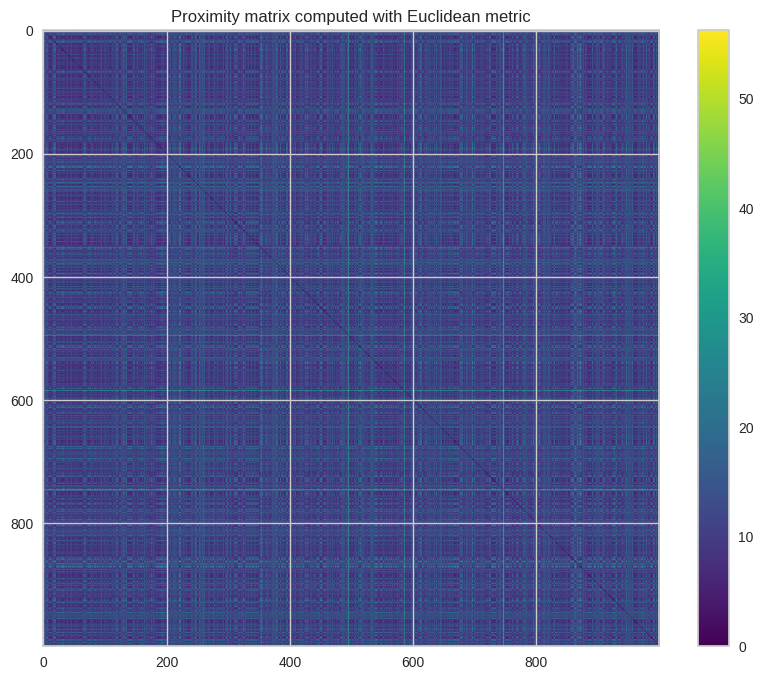

In [ ]:
# Visualize the dataset using the proximity matrix
# Use the complete normalized dataset
numericalData = dfNormalized.values
PM = pdist(numericalData, metric='euclidean')
PM = squareform(PM).round(2)

# Plot the proximity matrix
plt.figure(figsize=(10, 8))
plt.imshow(PM, cmap='viridis')
plt.title('Proximity matrix computed with Euclidean metric')
plt.colorbar()
plt.show()

In [ ]:
print(dfNormalized.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Zone                             1000 non-null   int64  
 1   Year                             1000 non-null   float64
 2   Latitude                         1000 non-null   float64
 3   Longitude                        1000 non-null   float64
 4   Altitude                         1000 non-null   float64
 5   t2m                              1000 non-null   float64
 6   ws                               1000 non-null   float64
 7   wd                               1000 non-null   float64
 8   tp                               1000 non-null   float64
 9   blh                              1000 non-null   float64
 10  ssr                              1000 non-null   float64
 11  CVD60                            1000 non-null   float64
 12  no2                  

# VISUALIZATION FUNCTION

In [ ]:
def pcaTsneVisualization(data2visualize, nComp, labels, pal, title="Dataset"):
    """
    Perform PCA and t-SNE visualization of the data with cluster labels
    """
    # PCA
    pca = PCA(n_components=nComp)
    pcaResult = pca.fit_transform(data2visualize)
    print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))

    # t-SNE
    print('\nApplying t-SNE...')
    np.random.seed(100)
    tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300, random_state=42)
    tsneResults = tsne.fit_transform(data2visualize)

    # Plots
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle(f'Dimensionality reduction of the {title}', fontsize=16)

    # Plot 1: PCA
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(pcaResult[:, 0], pcaResult[:, 1], c=labels, cmap='tab10', alpha=0.7)
    ax1.set_xlabel('PC1', fontsize=12)
    ax1.set_ylabel('PC2', fontsize=12)
    ax1.set_title('PCA')
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax1)

    # Plot 2: t-SNE
    ax2 = fig.add_subplot(122)
    scatter2 = ax2.scatter(tsneResults[:, 0], tsneResults[:, 1], c=labels, cmap='tab10', alpha=0.7)
    ax2.set_xlabel('t-SNE1', fontsize=12)
    ax2.set_ylabel('t-SNE2', fontsize=12)
    ax2.set_title('t-SNE')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=ax2)

    plt.tight_layout()
    plt.show()

# INTRA AND INTER CLUSTER DISTANCE FUNCTION

In [ ]:
def intraInterClusterDistances(data, k, labels, clusterCenters, distanceMetric):
    """
    Calculate intra-cluster and inter-cluster distances
    """
    # Intra-cluster distances (average over all pairwise distances)
    PM = pdist(data, metric=distanceMetric)
    PM = squareform(PM).round(2)

    d = np.zeros(k)
    for cluster in range(k):
        ind = np.where(labels == cluster)[0]
        if len(ind) > 1:
            clusterDistances = PM[np.ix_(ind, ind)]
            # Get upper triangular part (excluding diagonal)
            upperTriangular = np.triu(clusterDistances, k=1)
            d[cluster] = np.mean(upperTriangular[upperTriangular > 0])
        else:
            d[cluster] = 0

    print("The intra-cluster distance of the clusters are: ", d.round(2))

    # Inter-cluster distance
    D = pdist(clusterCenters, metric=distanceMetric)
    D = squareform(D).round(2)
    print("\nAll pair-wise inter-cluster distances:\n", D)

    return d, D

# FIND CLUSTER CENTERS FUNCTION

In [ ]:
def findClusterCenters(data, k, labels):
    """
    Find the centroids of each cluster
    """
    # Initialize the output
    clusterCenters = np.zeros((k, data.shape[1]))

    print("%d centroids are being computed, as we have %d clusters." % (k, k))

    for cluster in range(k):
        ind = np.where(labels == cluster)[0]
        if len(ind) > 0:
            clusterPoints = data[ind, :]
            clusterCenters[cluster, :] = np.mean(clusterPoints, axis=0)
            print("The centroid of cluster %d has coordinates: " % cluster, *clusterCenters[cluster, :].round(2))

    return clusterCenters

# CLUSTERING FUNCTIONS

## Hierarchical

In [ ]:
def findOptimalClustersHierarchical(data, maxClusters=10):
    """
    Find optimal number of clusters for hierarchical clustering using silhouette score
    """
    silhouetteScores = []
    clusterRange = range(2, maxClusters + 1)

    for k in clusterRange:
        model = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = model.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouetteScores.append(score)

    # Plot silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(clusterRange, silhouetteScores, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Agglomerative Clustering: Silhouette Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    bestSilhouetteK = clusterRange[np.argmax(silhouetteScores)]
    print(f"Optimal number of clusters based on silhouette score: {bestSilhouetteK}")
    print(f"Max silhouette score: {max(silhouetteScores):.4f}")

    return bestSilhouetteK, silhouetteScores

In [ ]:
def performHierarchicalClustering(data, targetClusters=None, maxDistance=100):
    """
    Perform hierarchical clustering with Ward linkage
    """
    # Compute the linkage matrix (Ward linkage)
    linkageMatrix = linkage(data, method='ward')

    # Visualize the dendrogram
    plt.figure(figsize=(15, 8))
    dendrogram(linkageMatrix, truncate_mode='level', p=30)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index or (cluster size)')
    plt.ylabel('Distance')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Choose the cut criterion
    if targetClusters is None:
        # Use distance criterion
        maxDistance = maxDistance
        hierarchicalLabels = fcluster(linkageMatrix, maxDistance, criterion='distance') - 1
    else:
        # Use number of clusters criterion
        hierarchicalLabels = fcluster(linkageMatrix, targetClusters, criterion='maxclust') - 1

    nClusters = len(np.unique(hierarchicalLabels))
    print(f"Hierarchical clustering produced {nClusters} clusters")

    # Find cluster centers
    clusterCenters = findClusterCenters(data, nClusters, hierarchicalLabels)

    # Compute intra and inter cluster distances
    intraDistances, interDistances = intraInterClusterDistances(data, nClusters, hierarchicalLabels, clusterCenters, 'euclidean')

    # Compute validation metrics
    silhouetteScoreValue = silhouette_score(data, hierarchicalLabels)

    print(f"Silhouette Score: {silhouetteScoreValue:.4f}")

    return hierarchicalLabels, nClusters, silhouetteScoreValue

## K-means++

In [ ]:
def findOptimalClustersKmeans(data, maxClusters=10, nInit=10):
    """
    Find optimal number of clusters for K-means using both elbow method and silhouette score
    """
    # Initialize KMeans model
    kmeans = KMeans(init='k-means++', n_init=nInit, max_iter=300, tol=0.0001, random_state=42)

    # Use KElbowVisualizer to find elbow point based on inertia
    elbowVisualizer = KElbowVisualizer(kmeans, k=(2, maxClusters), metric='distortion', timings=False)
    elbowVisualizer.fit(data)
    elbowVisualizer.show()

    # Get optimal number of clusters from elbow visualizer
    optimalClusters = elbowVisualizer.elbow_value_
    if optimalClusters is None:
        print("Warning: Elbow method did not find a clear elbow point")
        optimalClusters = 3  # Default value

    # Compute silhouette scores manually for each k
    silhouetteScores = []
    clusterRange = range(2, maxClusters + 1)

    for k in clusterRange:
        model = KMeans(n_clusters=k, init='k-means++', n_init=nInit, max_iter=300, tol=0.0001, random_state=42)
        model.fit(data)
        score = silhouette_score(data, model.labels_)
        silhouetteScores.append(score)

    # Plot silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(clusterRange, silhouetteScores, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('K-means++: Silhouette Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print results
    bestSilhouetteK = clusterRange[np.argmax(silhouetteScores)]
    print(f"Optimal number of clusters based on elbow (inertia): {optimalClusters}")
    print(f"Optimal number of clusters based on silhouette score: {bestSilhouetteK}")
    print(f"Max silhouette score: {max(silhouetteScores):.4f}")

    return optimalClusters, bestSilhouetteK, silhouetteScores

In [ ]:
def performKmeansPlusClustering(data, nClusters, nInit=10):
    """
    Perform K-means++ clustering
    """
    # Perform K-means++
    kmeans = KMeans(n_clusters=nClusters, init='k-means++', n_init=nInit,
                   max_iter=300, tol=0.0001, verbose=1, random_state=42)
    kmeans.fit(data)

    print(f'The final SSE is: {kmeans.inertia_:.2f}')

    # Scatterplot with two random features
    fig = plt.figure(figsize=(12, 5))

    # Random feature selection for 2D visualization
    np.random.seed(42)  # For reproducibility
    feat1 = np.random.randint(0, data.shape[1])
    feat2 = np.random.randint(0, data.shape[1])
    while feat2 == feat1:  # Ensure different features
        feat2 = np.random.randint(0, data.shape[1])

    plt.scatter(data[:, feat1], data[:, feat2], c=kmeans.labels_, cmap='tab10', alpha=0.7)
    plt.scatter(kmeans.cluster_centers_[:, feat1], kmeans.cluster_centers_[:, feat2],
               s=200, c='black', marker='X', linewidths=2, label='Centroids')
    plt.xlabel(f'Feature {feat1}')
    plt.ylabel(f'Feature {feat2}')
    plt.title('K-means++ Clustering Results')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Dimensionality reduction visualization
    pcaTsneVisualization(data, min(nClusters, data.shape[1]), kmeans.labels_, PAL, "K-means++ Clustering")

    # Compute intra and inter cluster distances
    intraDistances, interDistances = intraInterClusterDistances(data, nClusters, kmeans.labels_, kmeans.cluster_centers_, 'euclidean')

    # Compute validation metrics
    silhouetteScoreValue = silhouette_score(data, kmeans.labels_)

    print(f"Silhouette Score: {silhouetteScoreValue:.4f}")

    return kmeans.labels_, silhouetteScoreValue

## DBSCAN

In [ ]:
def findOptimalDbscanParameters(data, epsRange=None, minSamplesRange=None, useKneeLocator=True):
    """
    Find optimal parameters for DBSCAN using silhouette score and k-distance graph
    """

    if epsRange is None:
        # Use k-distance graph to estimate eps
        neighbors = NearestNeighbors(n_neighbors=4)
        neighbors.fit(data)
        distances, indices = neighbors.kneighbors(data)
        distances = np.sort(distances[:, 3], axis=0)

        # Plot k-distance graph
        plt.figure(figsize=(10, 6))
        plt.plot(distances, 'b-', linewidth=2)
        plt.xlabel('Points sorted by distance')
        plt.ylabel('4th nearest neighbor distance')
        plt.title('K-distance graph for DBSCAN parameter selection')
        plt.grid(True, alpha=0.3)

        if useKneeLocator:
            # Find the knee point
            kl = KneeLocator(range(len(distances)), distances,
                           curve='convex', direction='increasing')

            if kl.knee is not None:
                knee_eps = distances[kl.knee]
                plt.axhline(y=knee_eps, color='r', linestyle='--',
                          label=f'Knee point: {knee_eps:.4f}')
                plt.legend()
                print(f"Knee point found at eps = {knee_eps:.4f}")

                # Create range around knee point
                epsRange = np.linspace(knee_eps * 0.5, knee_eps * 1.5, 10)
            else:
                print("Warning: Knee point not found, using percentile method")
                epsRange = np.linspace(distances[int(len(distances)*0.1)],
                                     distances[int(len(distances)*0.9)], 10)
        else:
            # Use original percentile method
            epsRange = np.linspace(distances[int(len(distances)*0.1)],
                                 distances[int(len(distances)*0.9)], 10)

        plt.show()

    if minSamplesRange is None:
        minSamplesRange = range(3, 20, 2)

    bestScore = -1
    bestParams = None
    results = []

    print("Testing DBSCAN parameters...")
    for eps in epsRange:
        for minSamples in minSamplesRange:
            dbscan = DBSCAN(eps=eps, min_samples=minSamples)
            labels = dbscan.fit_predict(data)

            # Check if clustering was successful
            nClusters = len(set(labels)) - (1 if -1 in labels else 0)
            nNoise = list(labels).count(-1)

            if nClusters > 1 and nNoise < len(labels) * 0.8:  # Avoid too many noise points
                score = silhouette_score(data, labels)
                results.append((eps, minSamples, nClusters, nNoise, score))

                if score > bestScore:
                    bestScore = score
                    bestParams = (eps, minSamples)

    # Display results
    if results:
        results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'n_noise', 'silhouette_score'])
        print("\nTop 10 parameter combinations:")
        print(results_df.nlargest(10, 'silhouette_score'))

        print(f"\nBest parameters: eps={bestParams[0]:.4f}, min_samples={bestParams[1]}")
        print(f"Best silhouette score: {bestScore:.4f}")
    else:
        print("No valid clustering found. Try adjusting parameter ranges.")
        # Use knee point as default if available
        if useKneeLocator and 'knee_eps' in locals():
            bestParams = (knee_eps, 5)
        else:
            bestParams = (0.5, 5)  # Default values
        print(f"Using default parameters: eps={bestParams[0]:.4f}, min_samples={bestParams[1]}")

    return bestParams, results

In [ ]:
def performDbscanClustering(data, eps=0.5, minSamples=5):
    """
    Perform DBSCAN clustering
    """
    # Perform DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=minSamples)
    labels = dbscan.fit_predict(data)

    # Analyze results
    nClusters = len(set(labels)) - (1 if -1 in labels else 0)
    nNoise = list(labels).count(-1)

    print(f'Estimated number of clusters: {nClusters}')
    print(f'Estimated number of noise points: {nNoise}')

    # Visualize clusters
    if nClusters > 0:
        # Random feature selection for 2D visualization
        np.random.seed(42)
        feat1 = np.random.randint(0, data.shape[1])
        feat2 = np.random.randint(0, data.shape[1])
        while feat2 == feat1:
            feat2 = np.random.randint(0, data.shape[1])

        plt.figure(figsize=(12, 5))
        scatter = plt.scatter(data[:, feat1], data[:, feat2], c=labels, cmap='tab10', alpha=0.7)
        plt.xlabel(f'Feature {feat1}')
        plt.ylabel(f'Feature {feat2}')
        plt.title(f'DBSCAN Clustering Results (eps={eps}, min_samples={minSamples})')
        plt.colorbar(scatter)
        plt.grid(True, alpha=0.3)
        plt.show()

        # Dimensionality reduction visualization
        pcaTsneVisualization(data, min(nClusters, data.shape[1]), labels, PAL, "DBSCAN Clustering")

        # Compute validation metrics (only for non-noise points)
        if nClusters > 1:
            nonNoiseIndices = labels != -1
            if np.sum(nonNoiseIndices) > 0:
                silhouetteScoreValue = silhouette_score(data[nonNoiseIndices], labels[nonNoiseIndices])
                print(f"Silhouette Score (excluding noise): {silhouetteScoreValue:.4f}")
            else:
                silhouetteScoreValue = -1
        else:
            silhouetteScoreValue = -1
    else:
        silhouetteScoreValue = -1
        print("No clusters found. Try adjusting parameters.")

    return labels, nClusters, silhouetteScoreValue

# ANALYZE TYPE RELATIONSHIP FUNCTION

In [ ]:
def analyzeTypeRelationship(clusterLabels, clusterName, originalType):
    """
    Analyze the relationship between cluster labels and the original Type variable
    """
    print(f"=== {clusterName} vs Type Analysis ===")

    # Handle noise points in DBSCAN (convert -1 to a separate category)
    if -1 in clusterLabels:
        clusterLabelsAdjusted = clusterLabels.copy()
        clusterLabelsAdjusted[clusterLabelsAdjusted == -1] = max(clusterLabels) + 1
        clusterLabelsAdjusted = ['Noise' if x == max(clusterLabels) + 1 else f'Cluster_{x}' for x in clusterLabelsAdjusted]
    else:
        clusterLabelsAdjusted = [f'Cluster_{x}' for x in clusterLabels]

    # Create contingency table
    contingencyTable = pd.crosstab(originalType, clusterLabelsAdjusted)
    print("Contingency Table:")
    print(contingencyTable)

    # Calculate percentages
    percentageTable = pd.crosstab(originalType, clusterLabelsAdjusted, normalize='index') * 100
    print("\nPercentage distribution within each Type:")
    print(percentageTable.round(2))

    # Statistical test
    try:
        chi2, pValue, dof, expected = chi2_contingency(contingencyTable)
        print(f"\nChi-square test:")
        print(f"Chi-square statistic: {chi2:.4f}")
        print(f"P-value: {pValue:.4f}")
        print(f"Degrees of freedom: {dof}")

        if pValue < 0.05:
            print("There is a significant relationship between Type and clusters (p < 0.05)")
        else:
            print("No significant relationship between Type and clusters (p >= 0.05)")
    except:
        print("Cannot perform chi-square test (possibly due to small sample sizes)")

    return contingencyTable, percentageTable

# CLUSTERING ON FULL DATASET

In [ ]:
# Use the complete normalized dataset for clustering
X = dfNormalized.values
print(f"Data shape for clustering: {X.shape}")

Data shape for clustering: (1000, 35)


## Hierarchical Clustering

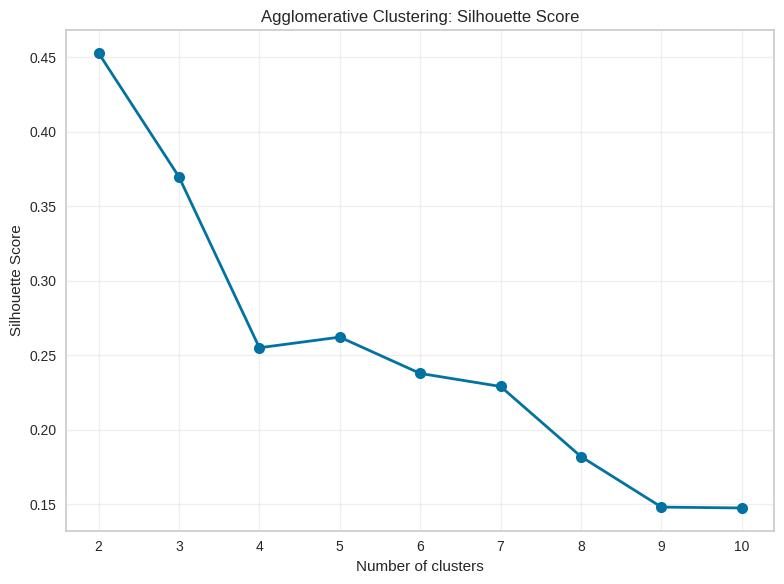

Optimal number of clusters based on silhouette score: 2
Max silhouette score: 0.4529


In [ ]:
# Find optimal number of clusters using silhouette score
hierarchicalClusters, hierarchicalSilhouetteScores = findOptimalClustersHierarchical(X, maxClusters=10)

--- Hierarchical Clustering with Distance Criterion ---


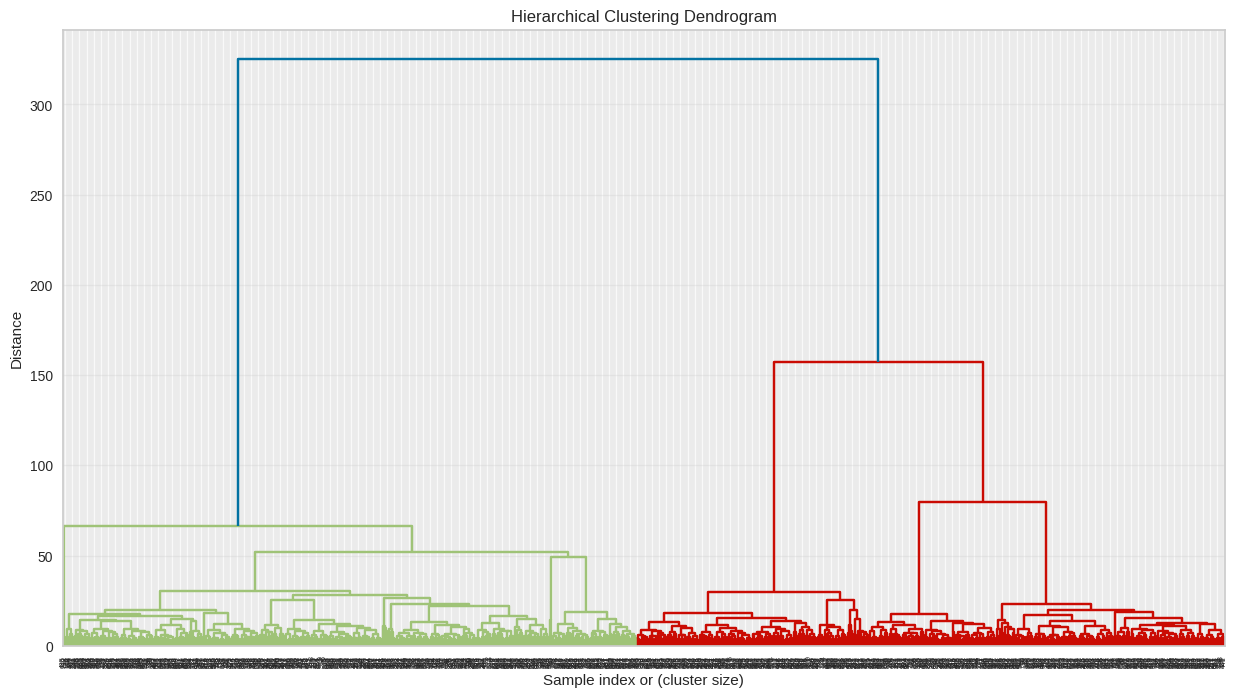

Hierarchical clustering produced 3 clusters
3 centroids are being computed, as we have 3 clusters.
The centroid of cluster 0 has coordinates:  7.11 -0.0 -0.01 -0.03 0.02 0.07 0.02 0.01 0.01 0.06 -0.07 -0.0 -0.06 0.0 0.05 0.01 0.03 0.03 -0.05 -0.02 0.03 -0.06 0.26 0.24 0.24 0.26 0.09 0.09 0.22 0.06 0.17 0.08 0.09 0.13 0.09
The centroid of cluster 1 has coordinates:  27.78 0.08 0.0 0.09 -0.0 -0.01 0.1 0.05 -0.01 0.03 0.07 -0.06 0.06 -0.07 -0.04 -0.06 -0.11 -0.14 0.11 -0.07 -0.03 0.07 0.23 0.27 0.29 0.22 0.08 0.07 0.24 0.05 0.13 0.15 0.09 0.11 0.1
The centroid of cluster 2 has coordinates:  17.66 -0.05 0.01 -0.01 -0.03 -0.1 -0.09 -0.04 -0.01 -0.11 0.07 0.04 0.06 0.04 -0.04 0.03 0.03 0.04 0.01 0.08 -0.03 0.06 0.24 0.28 0.21 0.26 0.07 0.08 0.25 0.06 0.12 0.12 0.07 0.15 0.07
The intra-cluster distance of the clusters are:  [7.1  6.49 7.42]

All pair-wise inter-cluster distances:
 [[ 0.   20.68 10.57]
 [20.68  0.   10.13]
 [10.57 10.13  0.  ]]
Silhouette Score: 0.3698


In [ ]:
# Perform Hierarchical Clustering using distance criterion
print("--- Hierarchical Clustering with Distance Criterion ---")
hierarchicalLabelsDistance, hierarchicalClusterDistance, hierarchicalSilhouetteDistance = performHierarchicalClustering(X)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(hierarchicalLabelsDistance, "Hierarchical Clustering", originalType);

=== Hierarchical Clustering vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1  Cluster_2
Type                                                
Background Rural            51         30         31
Background Suburban         21         10         11
Background Urban           249         88        139
Industrial Suburban          3          0          1
Industrial Urban            20         16         17
Traffic Urban              150         55        108

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1  Cluster_2
Type                                                
Background Rural         45.54      26.79      27.68
Background Suburban      50.00      23.81      26.19
Background Urban         52.31      18.49      29.20
Industrial Suburban      75.00       0.00      25.00
Industrial Urban         37.74      30.19      32.08
Traffic Urban            47.92      17.57      34.50

Chi-square test:
Chi-square statistic: 1

--- Hierarchical Clustering with Optimal Number of Clusters ---


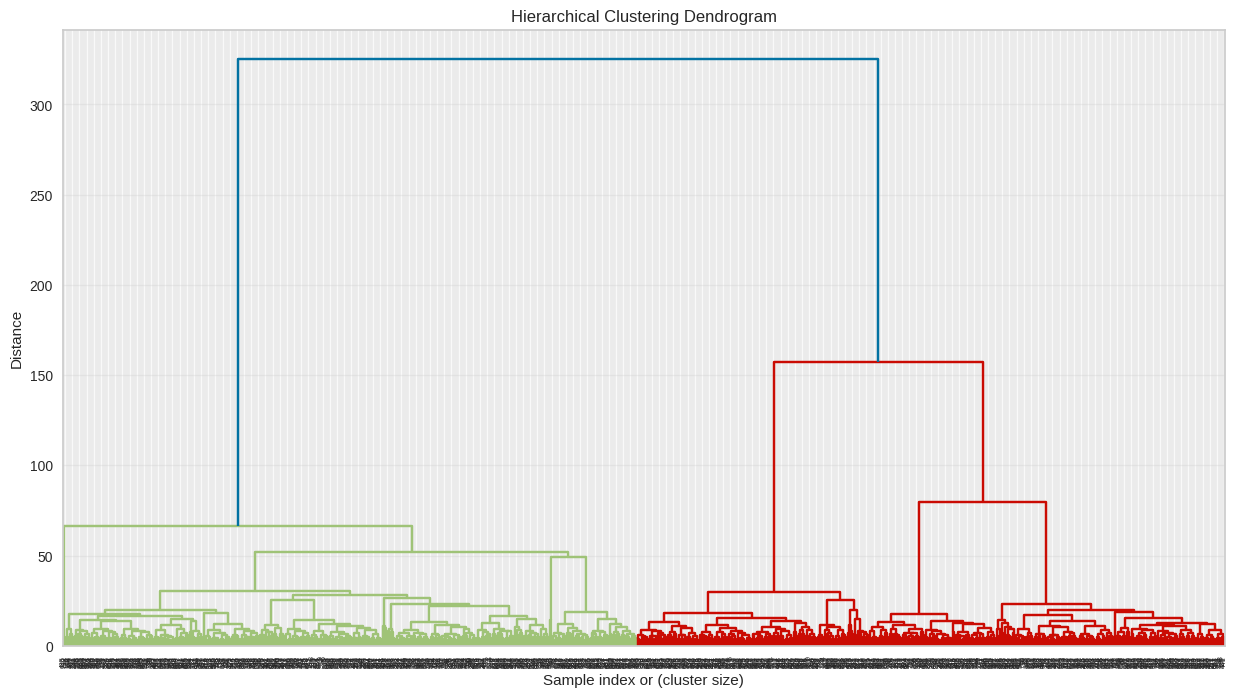

Hierarchical clustering produced 2 clusters
2 centroids are being computed, as we have 2 clusters.
The centroid of cluster 0 has coordinates:  7.11 -0.0 -0.01 -0.03 0.02 0.07 0.02 0.01 0.01 0.06 -0.07 -0.0 -0.06 0.0 0.05 0.01 0.03 0.03 -0.05 -0.02 0.03 -0.06 0.26 0.24 0.24 0.26 0.09 0.09 0.22 0.06 0.17 0.08 0.09 0.13 0.09
The centroid of cluster 1 has coordinates:  21.64 0.0 0.01 0.03 -0.02 -0.06 -0.02 -0.01 -0.01 -0.06 0.07 0.0 0.06 -0.0 -0.04 -0.01 -0.03 -0.03 0.05 0.02 -0.03 0.06 0.24 0.27 0.24 0.25 0.07 0.08 0.25 0.06 0.12 0.13 0.08 0.13 0.08
The intra-cluster distance of the clusters are:  [7.1  9.45]

All pair-wise inter-cluster distances:
 [[ 0.   14.54]
 [14.54  0.  ]]
Silhouette Score: 0.4529


In [ ]:
# Perform Hierarchical Clustering using optimal number of clusters
print("--- Hierarchical Clustering with Optimal Number of Clusters ---")
hierarchicalLabelsOptimal, hierarchicalNClustersOptimal, hierarchicalSilhouetteOptimal = performHierarchicalClustering(X, targetClusters=hierarchicalClusters)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(hierarchicalLabelsOptimal, "Hierarchical Clustering", originalType);

=== Hierarchical Clustering vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural            51         61
Background Suburban         21         21
Background Urban           249        227
Industrial Suburban          3          1
Industrial Urban            20         33
Traffic Urban              150        163

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural         45.54      54.46
Background Suburban      50.00      50.00
Background Urban         52.31      47.69
Industrial Suburban      75.00      25.00
Industrial Urban         37.74      62.26
Traffic Urban            47.92      52.08

Chi-square test:
Chi-square statistic: 6.4952
P-value: 0.2610
Degrees of freedom: 5
No significant relationship between Type and clusters (p >= 0.05)


## K-means++ Clustering

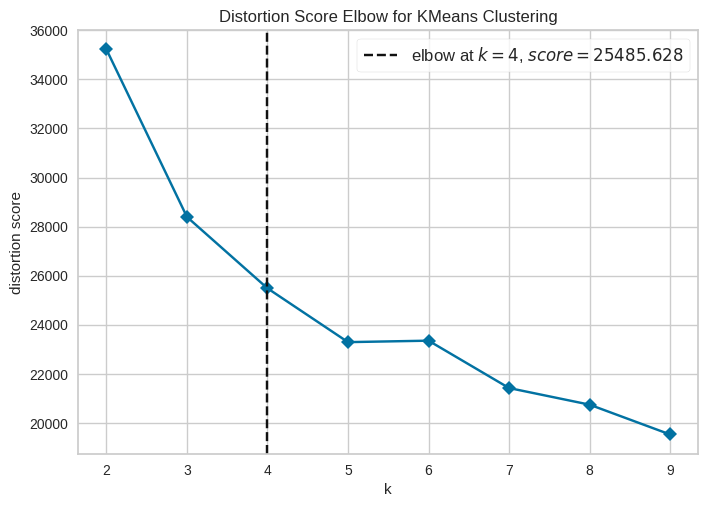

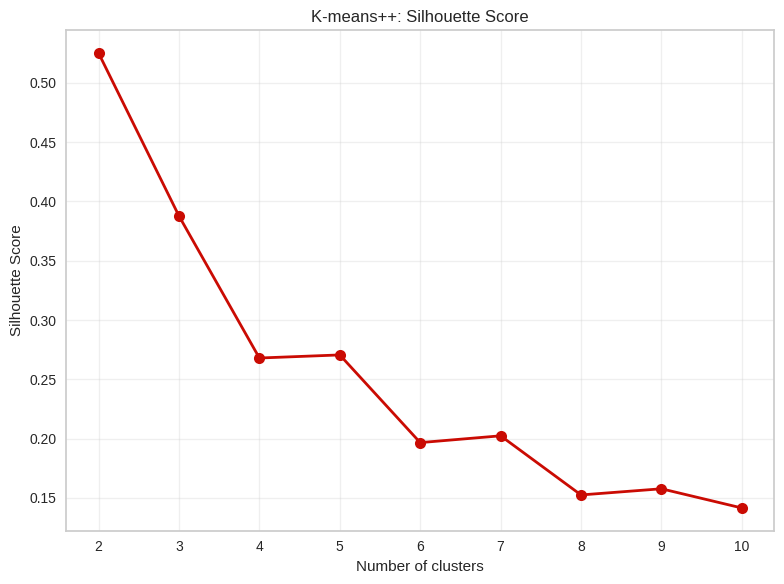

Optimal number of clusters based on elbow (inertia): 4
Optimal number of clusters based on silhouette score: 2
Max silhouette score: 0.5251


In [ ]:
# Find optimal number of clusters using both elbow method and silhouette score
kMeansClusters, kMeansSilhouetteK, kMeansSilhouetteScores = findOptimalClustersKmeans(X, maxClusters=10)

--- K-means++ Clustering with Elbow Method ---
Initialization complete
Iteration 0, inertia 36564.35345365519.
Iteration 1, inertia 28476.571952345173.
Iteration 2, inertia 27748.4028153596.
Iteration 3, inertia 26252.858323709235.
Iteration 4, inertia 25521.460996834503.
Iteration 5, inertia 25485.628402255352.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 41446.489856281725.
Iteration 1, inertia 28238.908973791553.
Iteration 2, inertia 27420.936095439865.
Iteration 3, inertia 26586.273106505345.
Iteration 4, inertia 26456.131150211266.
Iteration 5, inertia 26371.56442338965.
Iteration 6, inertia 26116.0696955599.
Iteration 7, inertia 25799.216199709022.
Iteration 8, inertia 25553.538804957378.
Iteration 9, inertia 25518.685032145175.
Iteration 10, inertia 25501.59872133889.
Iteration 11, inertia 25493.3429595118.
Iteration 12, inertia 25491.327252639687.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, in

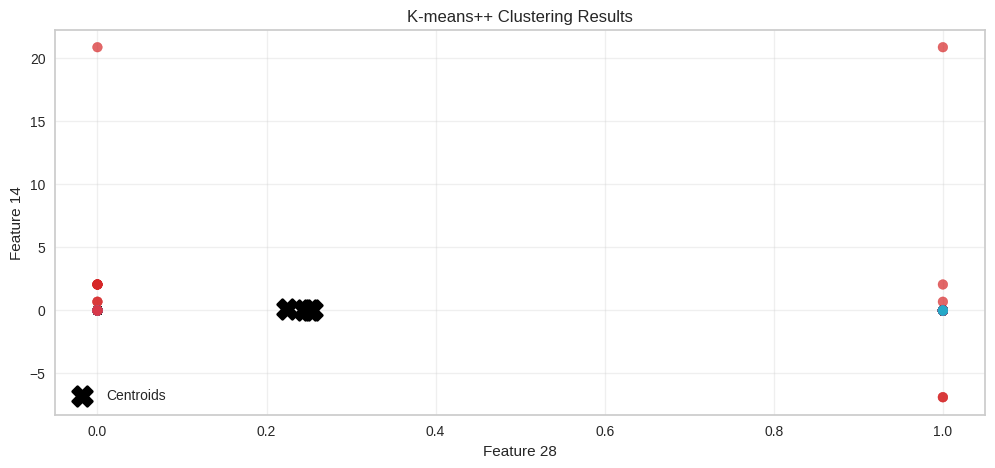

PCA: explained variation per principal component: [0.76 0.03 0.02 0.02]

Applying t-SNE...


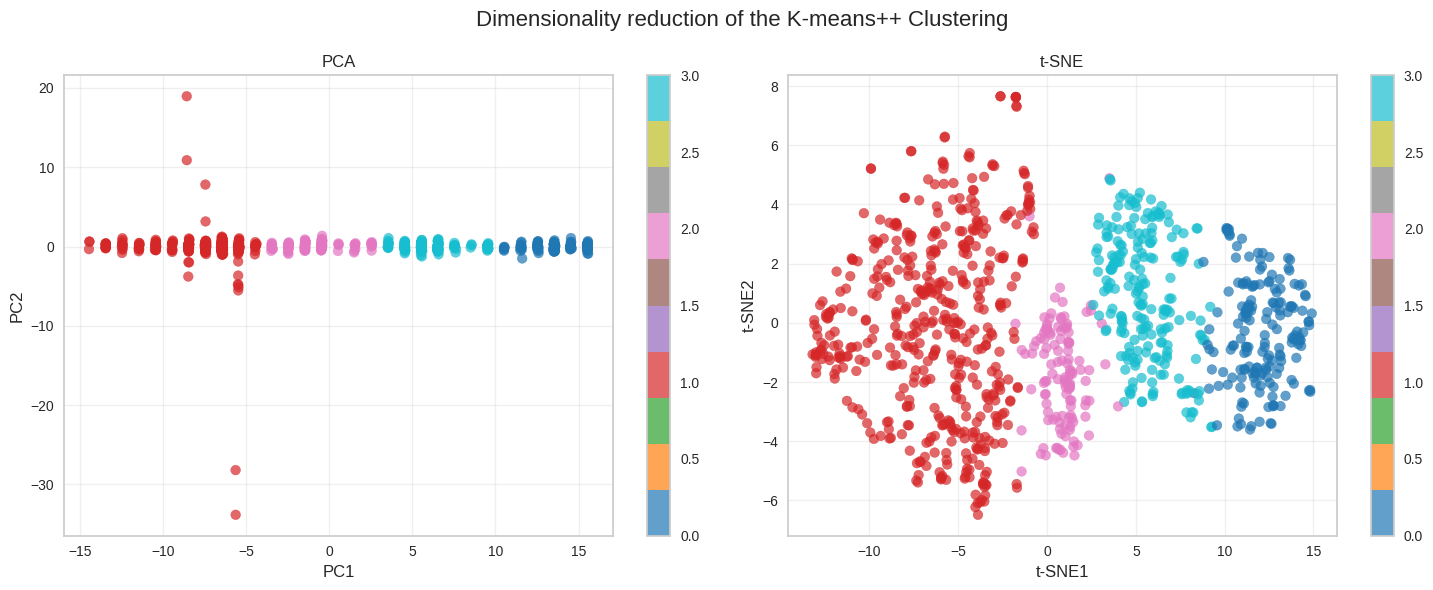

The intra-cluster distance of the clusters are:  [6.16 7.05 6.12 6.33]

All pair-wise inter-cluster distances:
 [[ 0.   21.24 14.71  7.72]
 [21.24  0.    6.55 13.54]
 [14.71  6.55  0.    7.01]
 [ 7.72 13.54  7.01  0.  ]]
Silhouette Score: 0.2680


In [ ]:
# Perform K-means++ Clustering using elbow method result
print("--- K-means++ Clustering with Elbow Method ---")
kmeansLabelsElbow, kmeansSilhouetteElbow = performKmeansPlusClustering(X, kMeansClusters)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(kmeansLabelsElbow, "K-means++ (Elbow Method)", originalType);

=== K-means++ (Elbow Method) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1  Cluster_2  Cluster_3
Type                                                           
Background Rural            28         51         12         21
Background Suburban          9         21          4          8
Background Urban            74        246         61         95
Industrial Suburban          0          3          1          0
Industrial Urban            12         20          5         16
Traffic Urban               53        150         39         71

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1  Cluster_2  Cluster_3
Type                                                           
Background Rural         25.00      45.54      10.71      18.75
Background Suburban      21.43      50.00       9.52      19.05
Background Urban         15.55      51.68      12.82      19.96
Industrial Suburban       0.00      75.00      25.00    

--- K-means++ Clustering with Silhouette Score ---
Initialization complete
Iteration 0, inertia 62745.95981789979.
Iteration 1, inertia 35217.142073131676.
Iteration 2, inertia 35215.9788251836.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 61757.172208549244.
Iteration 1, inertia 37276.86371119575.
Iteration 2, inertia 35238.03011004706.
Iteration 3, inertia 35228.3645377577.
Iteration 4, inertia 35216.29748419279.
Iteration 5, inertia 35215.9788251836.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 57995.38259903428.
Iteration 1, inertia 35241.935802406726.
Iteration 2, inertia 35215.9788251836.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 54415.56819774045.
Iteration 1, inertia 35564.438008049394.
Iteration 2, inertia 35228.3645377577.
Iteration 3, inertia 35216.29748419279.
Iteration 4, inertia 35215.9788251836.
Converged at iteration 4: strict conv

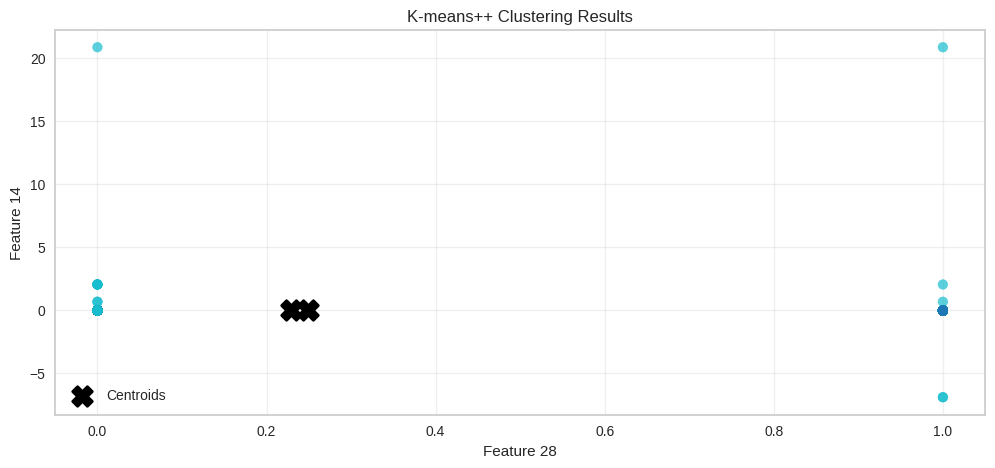

PCA: explained variation per principal component: [0.76 0.03]

Applying t-SNE...


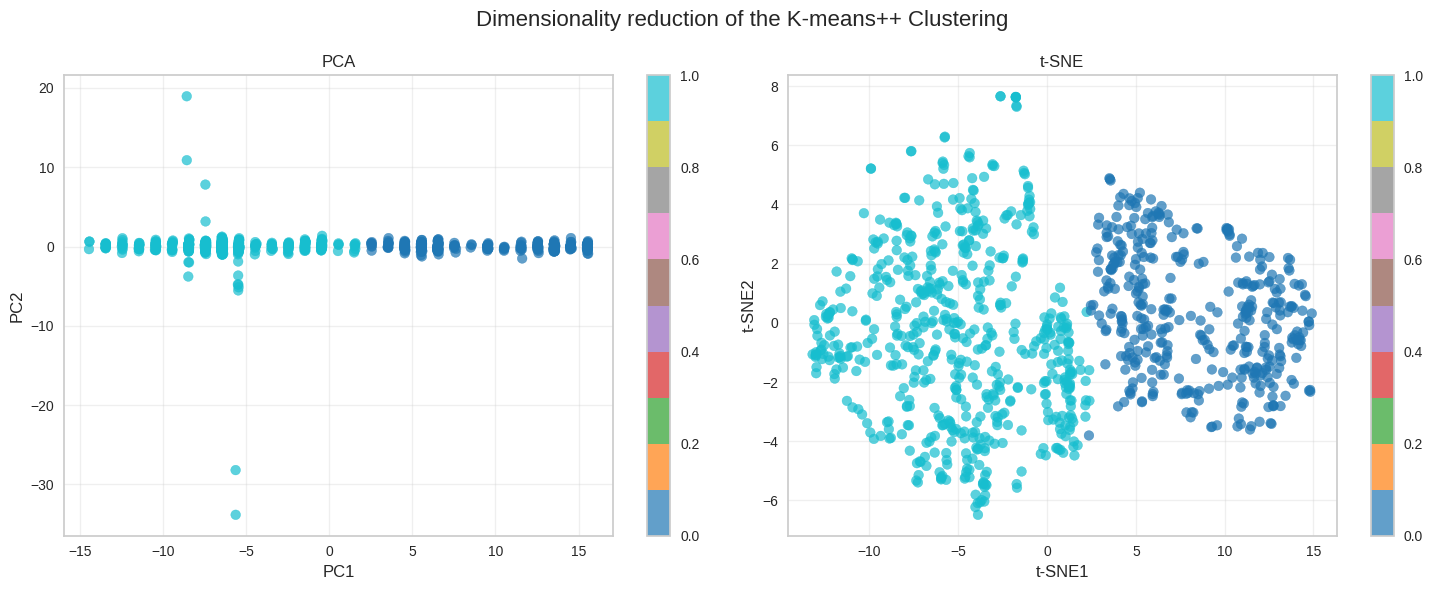

The intra-cluster distance of the clusters are:  [8.11 7.64]

All pair-wise inter-cluster distances:
 [[ 0.   15.71]
 [15.71  0.  ]]
Silhouette Score: 0.5251


In [ ]:
# Perform K-means++ Clustering using silhouette score result
print("--- K-means++ Clustering with Silhouette Score ---")
kmeansLabelsSilhouette, kmeansSilhouetteSilhouette = performKmeansPlusClustering(X, kMeansSilhouetteK)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(kmeansLabelsSilhouette, "K-means++ (Silhouette Score)", originalType);

=== K-means++ (Silhouette Score) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural            49         63
Background Suburban         17         25
Background Urban           173        303
Industrial Suburban          0          4
Industrial Urban            28         25
Traffic Urban              127        186

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural         43.75      56.25
Background Suburban      40.48      59.52
Background Urban         36.34      63.66
Industrial Suburban       0.00     100.00
Industrial Urban         52.83      47.17
Traffic Urban            40.58      59.42

Chi-square test:
Chi-square statistic: 9.5547
P-value: 0.0889
Degrees of freedom: 5
No significant relationship between Type and clusters (p >= 0.05)


## DBSCAN Clustering

--- Finding Optimal DBSCAN Parameters ---
Knee point found at eps = 6.0554


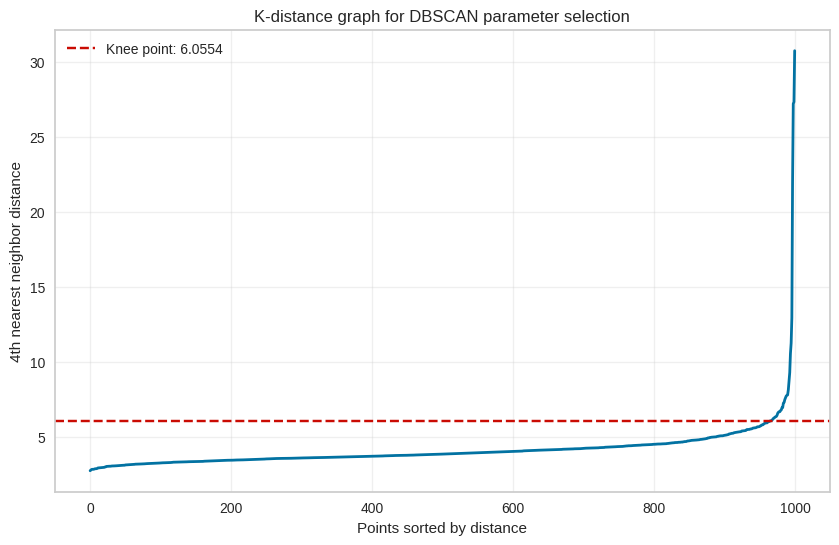

Testing DBSCAN parameters...

Top 10 parameter combinations:
         eps  min_samples  n_clusters  n_noise  silhouette_score
8   4.373339            9           3      183          0.266647
9   4.373339           11           3      191          0.260793
10  4.373339           13           3      196          0.257480
11  4.373339           15           3      211          0.248793
12  4.373339           17           3      217          0.243438
13  4.373339           19           3      234          0.232035
15  5.718981            3           2       29          0.029442
14  5.046160            3           2       67         -0.014965
0   3.700517            3           4      392         -0.053888
1   3.700517            5           7      436         -0.086899

Best parameters: eps=4.3733, min_samples=9
Best silhouette score: 0.2666


In [ ]:
# Find optimal DBSCAN parameters
print("--- Finding Optimal DBSCAN Parameters ---")
optimalDbscanParams, dbscanResults = findOptimalDbscanParameters(X)


--- DBSCAN Clustering with Optimal Parameters ---
Estimated number of clusters: 3
Estimated number of noise points: 183


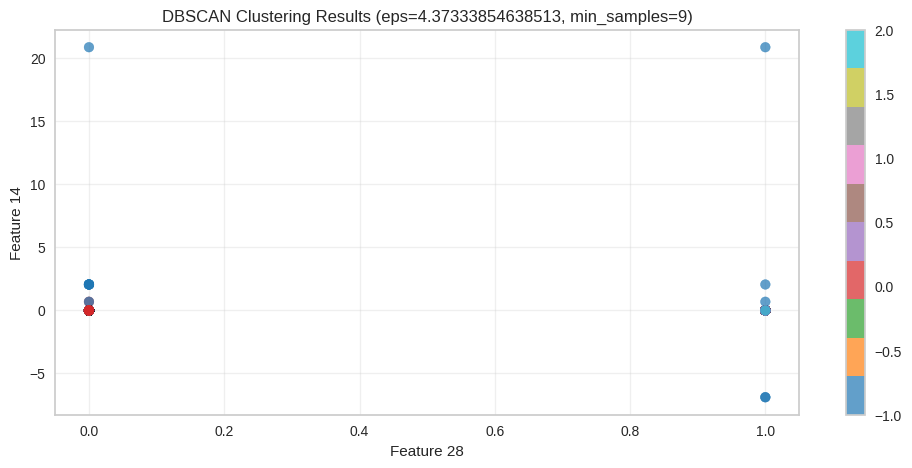

PCA: explained variation per principal component: [0.76 0.03 0.02]

Applying t-SNE...


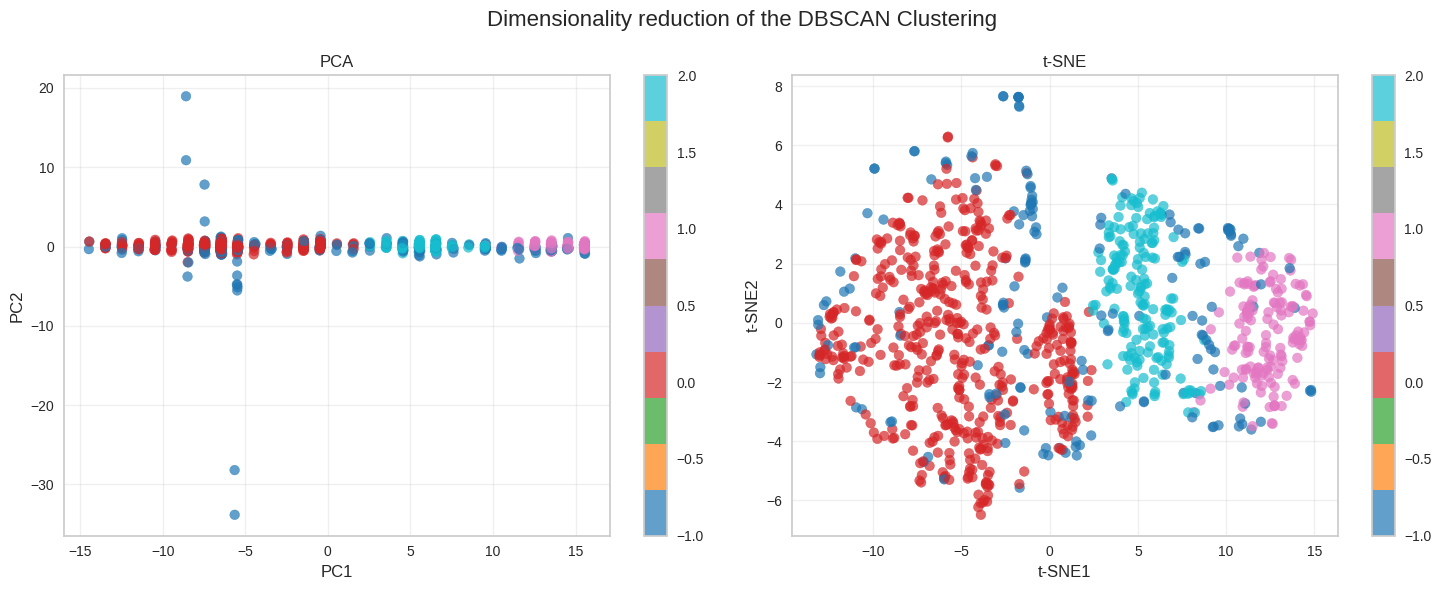

Silhouette Score (excluding noise): 0.4459


In [ ]:
# Perform DBSCAN with optimal parameters
print("\n--- DBSCAN Clustering with Optimal Parameters ---")
dbscanLabels, dbscanNClusters, dbscanSilhouette = performDbscanClustering(X, eps=optimalDbscanParams[0], minSamples=optimalDbscanParams[1])

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(dbscanLabels, "DBSCAN Clustering", originalType);

=== DBSCAN Clustering vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1  Cluster_2  Noise
Type                                                       
Background Rural            41         20         13     38
Background Suburban         15          9          6     12
Background Urban           256         59         81     80
Industrial Suburban          4          0          0      0
Industrial Urban            21         10         14      8
Traffic Urban              157         47         64     45

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1  Cluster_2  Noise
Type                                                       
Background Rural         36.61      17.86      11.61  33.93
Background Suburban      35.71      21.43      14.29  28.57
Background Urban         53.78      12.39      17.02  16.81
Industrial Suburban     100.00       0.00       0.00   0.00
Industrial Urban         39.62      18.87      26.42  1

## Result comparison

In [ ]:
# Create summary table of all clustering results
clusteringResults = []

# Hierarchical (optimal - Silhouette)
clusteringResults.append({
    'Method': 'Hierarchical (Optimal)',
    'Number of Clusters': hierarchicalNClustersOptimal,
    'Silhouette Score': hierarchicalSilhouetteOptimal,
    'Parameters': f'linkage=ward, n_clusters={hierarchicalClusters}'
})

# Hierarchical (distance)
clusteringResults.append({
    'Method': 'Hierarchical (Distance)',
    'Number of Clusters': hierarchicalClusterDistance,
    'Silhouette Score': hierarchicalSilhouetteDistance,
    'Parameters': f'linkage=ward, distance=100'
})

# K-means++ (elbow)
clusteringResults.append({
    'Method': 'K-means++ (Elbow)',
    'Number of Clusters': kMeansClusters,
    'Silhouette Score': kmeansSilhouetteElbow,
    'Parameters': f'n_clusters={kMeansClusters}, init=k-means++'
})

# K-means++ (silhouette)
clusteringResults.append({
    'Method': 'K-means++ (Silhouette)',
    'Number of Clusters': kMeansSilhouetteK,
    'Silhouette Score': kmeansSilhouetteSilhouette,
    'Parameters': f'n_clusters={kMeansSilhouetteK}, init=k-means++'
})

# DBSCAN
if dbscanNClusters > 0:
    clusteringResults.append({
        'Method': 'DBSCAN',
        'Number of Clusters': dbscanNClusters,
        'Silhouette Score': dbscanSilhouette,
        'Parameters': f'eps={optimalDbscanParams[0]:.4f}, min_samples={optimalDbscanParams[1]}'
    })

# Display results
resultsDF = pd.DataFrame(clusteringResults)
print("\n=== CLUSTERING RESULTS SUMMARY ===")
print(resultsDF.to_string(index=False))


=== CLUSTERING RESULTS SUMMARY ===
                 Method  Number of Clusters  Silhouette Score                   Parameters
 Hierarchical (Optimal)                   2          0.452931   linkage=ward, n_clusters=2
Hierarchical (Distance)                   3          0.369809   linkage=ward, distance=100
      K-means++ (Elbow)                   4          0.267971 n_clusters=4, init=k-means++
 K-means++ (Silhouette)                   2          0.525137 n_clusters=2, init=k-means++
                 DBSCAN                   3          0.445915    eps=4.3733, min_samples=9


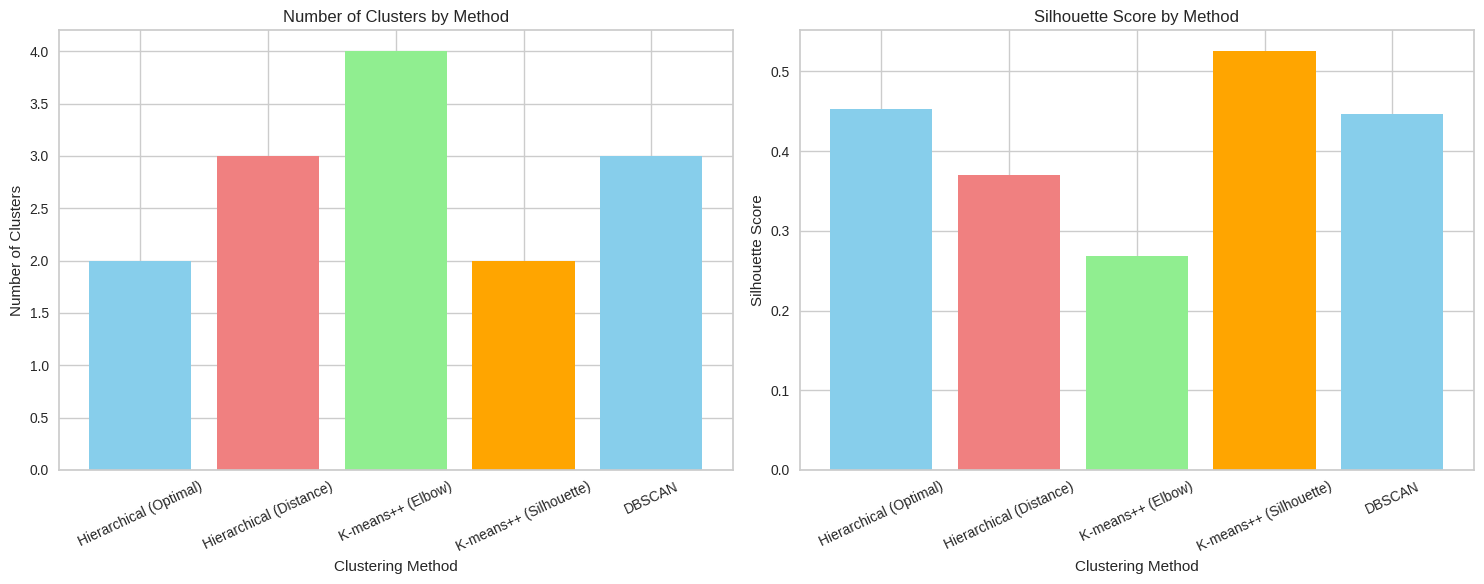

In [ ]:
# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Number of clusters comparison
methods = resultsDF['Method']
nClusters = resultsDF['Number of Clusters']
silhouetteScores = resultsDF['Silhouette Score']

ax1.bar(methods, nClusters, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'][:len(methods)])
ax1.set_xlabel('Clustering Method')
ax1.set_ylabel('Number of Clusters')
ax1.set_title('Number of Clusters by Method')
ax1.tick_params(axis='x', rotation=25)

# Silhouette score comparison
ax2.bar(methods, silhouetteScores, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'][:len(methods)])
ax2.set_xlabel('Clustering Method')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by Method')
ax2.tick_params(axis='x', rotation=25)

plt.tight_layout()
plt.show()

In [ ]:
# Determine best method
bestMethod = resultsDF.loc[resultsDF['Silhouette Score'].idxmax()]
print(f"Best clustering method based on silhouette score:")
print(f"Method: {bestMethod['Method']}")
print(f"Number of Clusters: {bestMethod['Number of Clusters']}")
print(f"Silhouette Score: {bestMethod['Silhouette Score']:.4f}")

Best clustering method based on silhouette score:
Method: K-means++ (Silhouette)
Number of Clusters: 2
Silhouette Score: 0.5251


# CLUSTERING AFTER OUTLIER REMOVAL

## Outlier detection and removal

In [ ]:
def detectOutliers(data, contamination=0.1):
    print(f"Detecting outliers with contamination factor: {contamination}")

    isolationForest = IsolationForest(contamination=contamination, random_state=42)
    isolationOutliers = isolationForest.fit_predict(data)

    # Convert to boolean mask
    isolationOutliers = isolationOutliers == -1

    print(f"Isolation Forest detected {np.sum(isolationOutliers)} outliers")

    # Random 2D visualization
    np.random.seed(42)
    feat1 = np.random.randint(0, data.shape[1])
    feat2 = np.random.randint(0, data.shape[1])
    while feat2 == feat1:
        feat2 = np.random.randint(0, data.shape[1])

    plt.figure(figsize=(8, 6))
    colors = ['blue' if not outlier else 'red' for outlier in isolationOutliers]
    plt.scatter(data[:, feat1], data[:, feat2], c=colors, alpha=0.7, s=20)
    plt.title(f'Isolation Forest Outliers ({np.sum(isolationOutliers)} outliers)')
    plt.xlabel(f'Feature {feat1}')
    plt.ylabel(f'Feature {feat2}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return isolationOutliers

Detecting outliers with contamination factor: 0.05
Isolation Forest detected 50 outliers


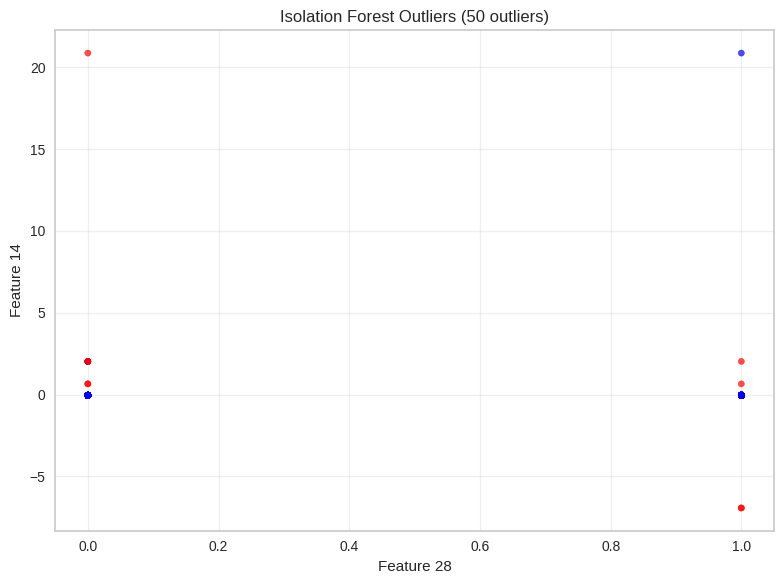

In [ ]:
# Detect outliers
outlierMask = detectOutliers(X, contamination=0.05)

In [ ]:
def removeOutliers(data, outlierMask, originalType):
    print(f"Original dataset shape: {data.shape}")
    print(f"Removing {np.sum(outlierMask)} outliers")

    # Remove outliers
    cleanData = data[~outlierMask]
    cleanType = originalType[~outlierMask]

    print(f"Clean dataset shape: {cleanData.shape}")
    print(f"Percentage of data retained: {(cleanData.shape[0] / data.shape[0]) * 100:.2f}%")

    return cleanData, cleanType

In [ ]:
# Remove outliers from the dataset
XOutlier, originalTypeOutlier = removeOutliers(X, outlierMask, originalType)

Original dataset shape: (1000, 35)
Removing 50 outliers
Clean dataset shape: (950, 35)
Percentage of data retained: 95.00%


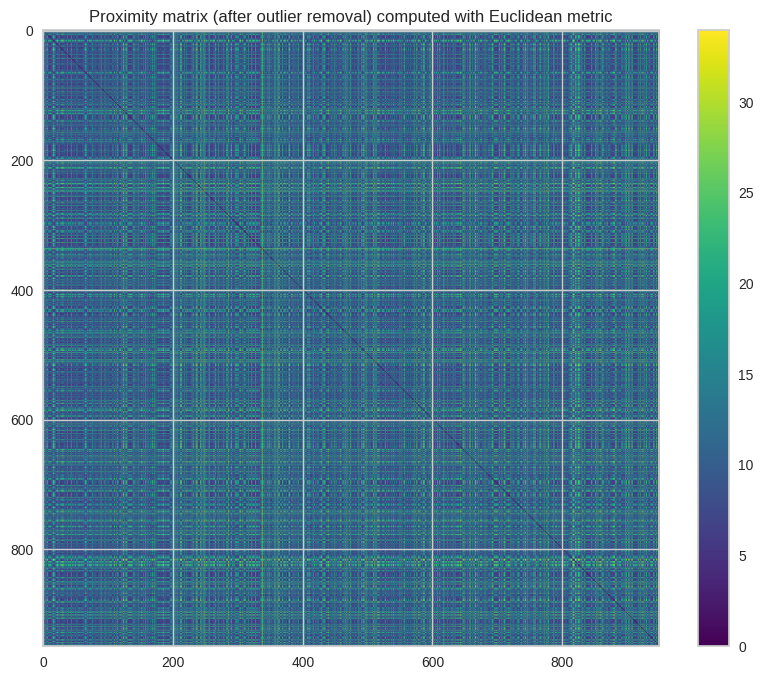

Clean dataset info:
Shape: (950, 35)


In [ ]:
# Visualize the clean dataset using proximity matrix
numericalDataOutlier = XOutlier
PM_outlier = pdist(numericalDataOutlier, metric='euclidean')
PM_outlier = squareform(PM_outlier).round(2)

# Plot the proximity matrix for clean data
plt.figure(figsize=(10, 8))
plt.imshow(PM_outlier, cmap='viridis')
plt.title('Proximity matrix (after outlier removal) computed with Euclidean metric')
plt.colorbar()
plt.show()

print("Clean dataset info:")
print(f"Shape: {XOutlier.shape}")

## Hierarchical Clustering

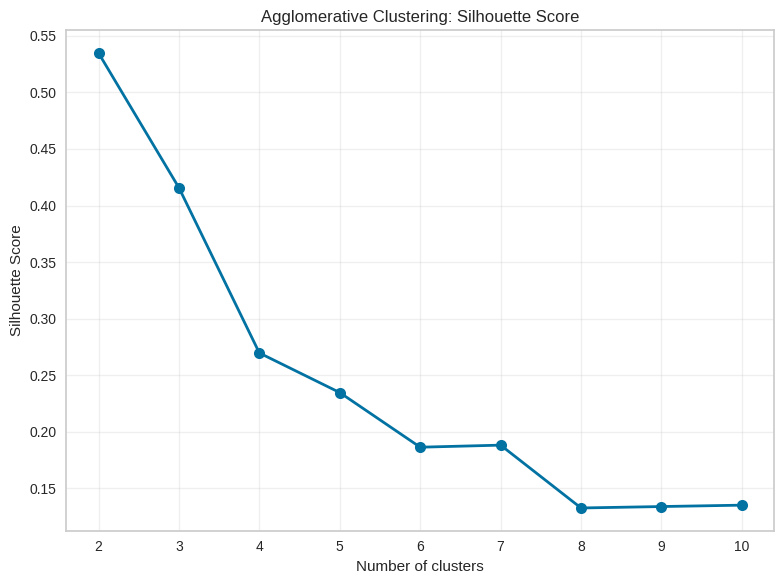

Optimal number of clusters based on silhouette score: 2
Max silhouette score: 0.5348


In [ ]:
# Find optimal number of clusters using silhouette score
hierarchicalClustersOutlier, hierarchicalSilhouetteScoresOutlier = findOptimalClustersHierarchical(XOutlier, maxClusters=10)

--- Hierarchical Clustering with Distance Criterion (After Outlier Removal) ---


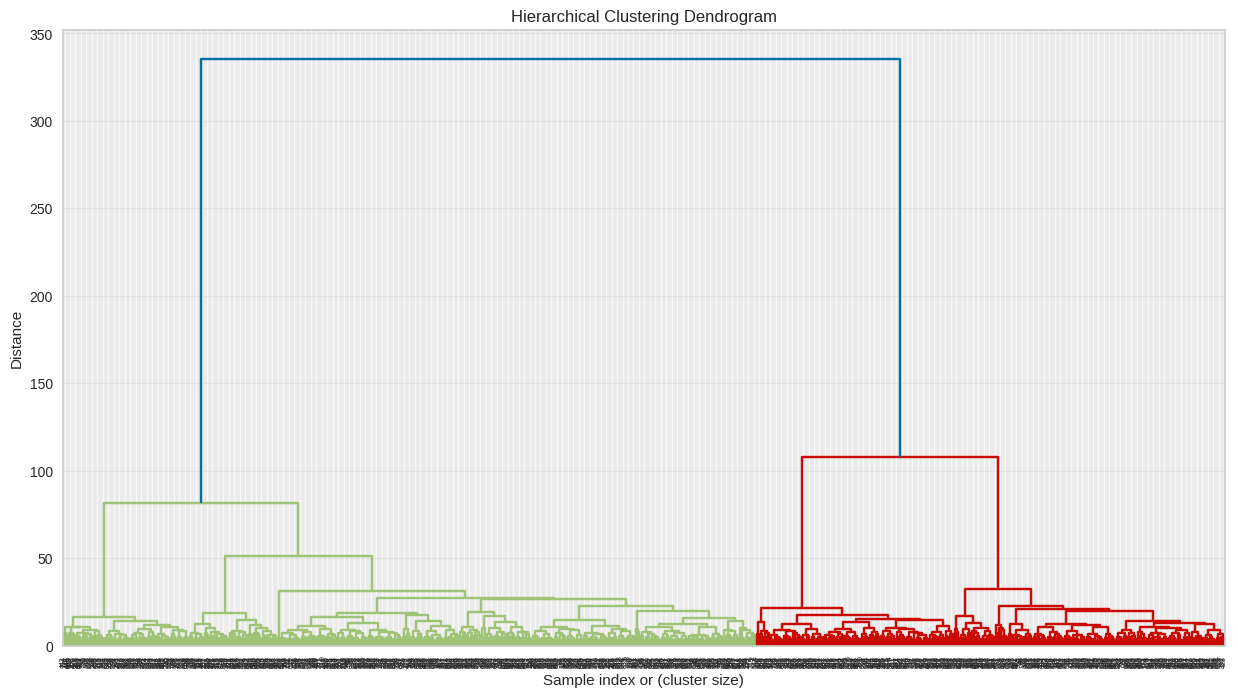

Hierarchical clustering produced 3 clusters
3 centroids are being computed, as we have 3 clusters.
The centroid of cluster 0 has coordinates:  8.22 -0.03 -0.02 -0.02 0.04 0.05 0.02 0.01 -0.02 0.03 0.07 -0.0 0.05 -0.06 -0.0 0.1 0.1 -0.0 -0.03 -0.01 0.04 -0.03 0.28 0.24 0.24 0.25 0.08 0.09 0.23 0.06 0.16 0.08 0.08 0.13 0.08
The centroid of cluster 1 has coordinates:  28.44 0.05 -0.01 0.11 -0.04 -0.1 0.1 0.04 -0.0 0.03 0.07 -0.06 0.06 0.01 -0.04 0.04 -0.05 -0.0 0.16 0.03 -0.05 0.07 0.23 0.26 0.3 0.2 0.09 0.05 0.23 0.04 0.14 0.16 0.09 0.11 0.09
The centroid of cluster 2 has coordinates:  20.57 -0.09 0.04 -0.01 -0.07 -0.06 -0.16 -0.02 -0.01 -0.17 0.07 0.01 0.06 0.02 -0.04 0.01 -0.06 -0.06 -0.01 0.01 -0.03 0.05 0.19 0.29 0.21 0.3 0.06 0.08 0.26 0.04 0.12 0.12 0.08 0.16 0.07
The intra-cluster distance of the clusters are:  [7.17 5.91 6.41]

All pair-wise inter-cluster distances:
 [[ 0.   20.23 12.36]
 [20.23  0.    7.89]
 [12.36  7.89  0.  ]]
Silhouette Score: 0.4156


In [ ]:
# Perform Hierarchical Clustering using distance criterion
print("--- Hierarchical Clustering with Distance Criterion (After Outlier Removal) ---")
hierarchicalLabelsDistanceOutlier, hierarchicalClusterDistanceOutlier, hierarchicalSilhouetteDistanceOutlier = performHierarchicalClustering(XOutlier)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(hierarchicalLabelsDistanceOutlier, "Hierarchical Clustering (Clean Data)", originalTypeOutlier);

=== Hierarchical Clustering (Clean Data) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1  Cluster_2
Type                                                
Background Rural            54         24         24
Background Suburban         16          9          7
Background Urban           288         68         99
Industrial Suburban          4          0          0
Industrial Urban            23         11         16
Traffic Urban              182         50         75

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1  Cluster_2
Type                                                
Background Rural         52.94      23.53      23.53
Background Suburban      50.00      28.12      21.88
Background Urban         63.30      14.95      21.76
Industrial Suburban     100.00       0.00       0.00
Industrial Urban         46.00      22.00      32.00
Traffic Urban            59.28      16.29      24.43

Chi-square test:
Chi-square

--- Hierarchical Clustering with Optimal Number of Clusters (After Outlier Removal) ---


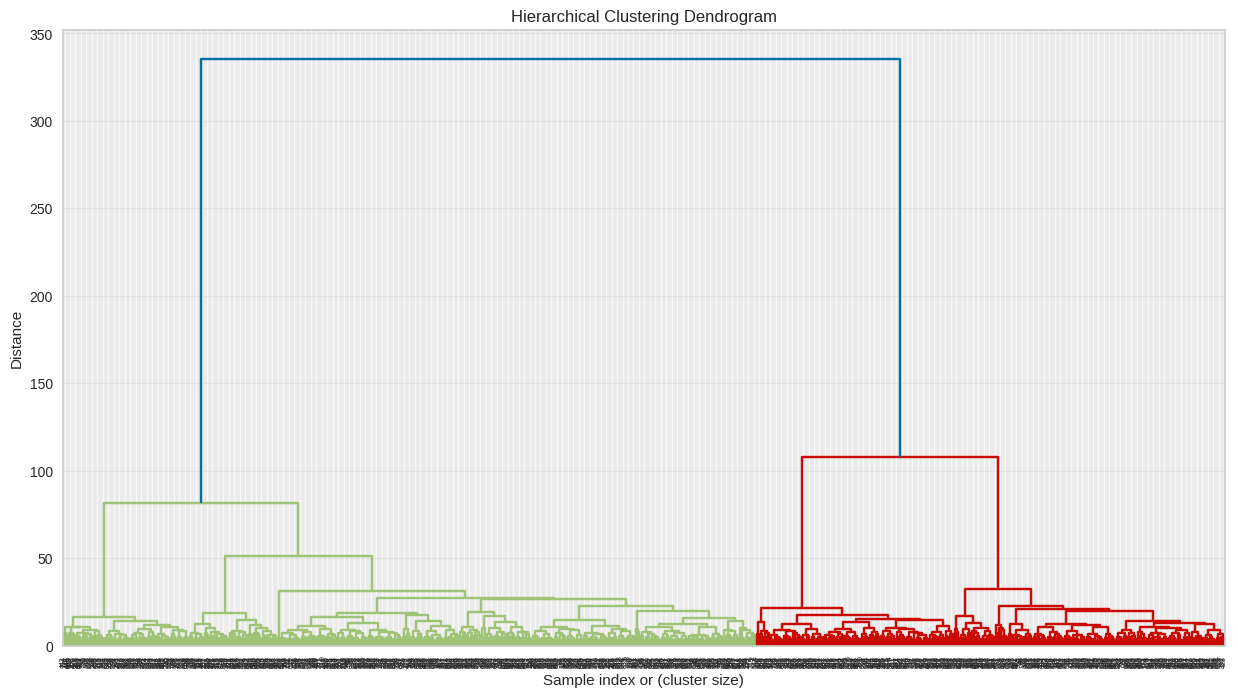

Hierarchical clustering produced 2 clusters
2 centroids are being computed, as we have 2 clusters.
The centroid of cluster 0 has coordinates:  8.22 -0.03 -0.02 -0.02 0.04 0.05 0.02 0.01 -0.02 0.03 0.07 -0.0 0.05 -0.06 -0.0 0.1 0.1 -0.0 -0.03 -0.01 0.04 -0.03 0.28 0.24 0.24 0.25 0.08 0.09 0.23 0.06 0.16 0.08 0.08 0.13 0.08
The centroid of cluster 1 has coordinates:  23.9 -0.03 0.02 0.04 -0.06 -0.08 -0.05 0.0 -0.01 -0.09 0.07 -0.02 0.06 0.02 -0.04 0.02 -0.06 -0.03 0.06 0.02 -0.04 0.06 0.21 0.28 0.25 0.26 0.07 0.07 0.25 0.04 0.13 0.14 0.08 0.14 0.08
The intra-cluster distance of the clusters are:  [7.17 8.04]

All pair-wise inter-cluster distances:
 [[ 0.   15.68]
 [15.68  0.  ]]
Silhouette Score: 0.5348


In [ ]:
# Perform Hierarchical Clustering using optimal number of clusters
print("--- Hierarchical Clustering with Optimal Number of Clusters (After Outlier Removal) ---")
hierarchicalLabelsOptimalOutlier, hierarchicalNClustersOptimalOutlier, hierarchicalSilhouetteOptimalOutlier = performHierarchicalClustering(XOutlier, targetClusters=hierarchicalClustersOutlier)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(hierarchicalLabelsOptimalOutlier, "Hierarchical Clustering (Clean Data)", originalTypeOutlier);

=== Hierarchical Clustering (Clean Data) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural            54         48
Background Suburban         16         16
Background Urban           288        167
Industrial Suburban          4          0
Industrial Urban            23         27
Traffic Urban              182        125

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural         52.94      47.06
Background Suburban      50.00      50.00
Background Urban         63.30      36.70
Industrial Suburban     100.00       0.00
Industrial Urban         46.00      54.00
Traffic Urban            59.28      40.72

Chi-square test:
Chi-square statistic: 12.2559
P-value: 0.0314
Degrees of freedom: 5
There is a significant relationship between Type and clusters (p < 0.05)


## K-means++ Clustering

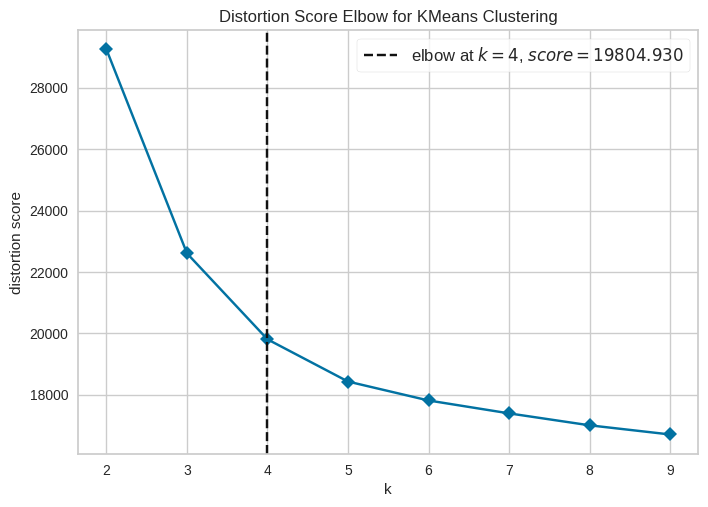

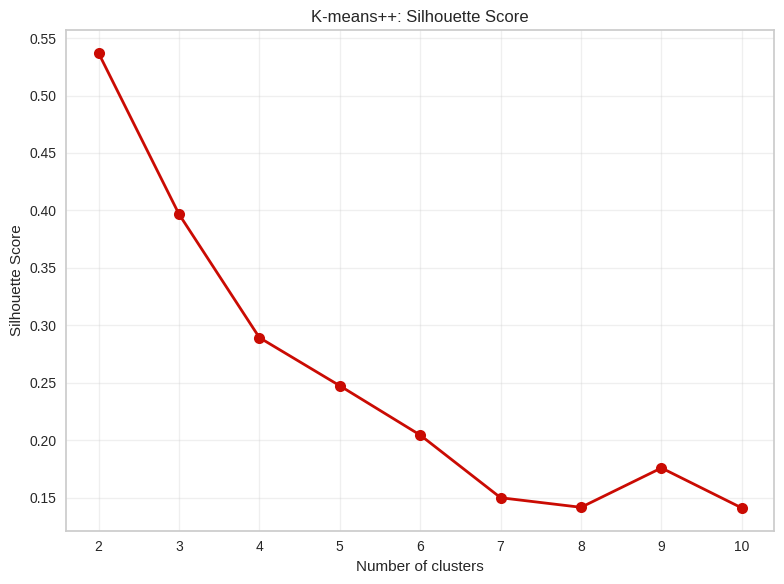

Optimal number of clusters based on elbow (inertia): 4
Optimal number of clusters based on silhouette score: 2
Max silhouette score: 0.5370


In [ ]:
# Find optimal number of clusters using both elbow method and silhouette score
kMeansClustersOutlier, kMeansSilhouetteKOutlier, kMeansSilhouetteScoresOutlier = findOptimalClustersKmeans(XOutlier, maxClusters=10)

--- K-means++ Clustering with Elbow Method (After Outlier Removal) ---
Initialization complete
Iteration 0, inertia 36094.84860940254.
Iteration 1, inertia 21325.134205541293.
Iteration 2, inertia 20048.51211920792.
Iteration 3, inertia 19811.05930636751.
Iteration 4, inertia 19804.929666185963.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 37939.4966440117.
Iteration 1, inertia 24960.233975158408.
Iteration 2, inertia 23985.337599442693.
Iteration 3, inertia 23680.555109004727.
Iteration 4, inertia 23460.67148025843.
Iteration 5, inertia 23446.00844694477.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 33683.46455105443.
Iteration 1, inertia 21578.66596012312.
Iteration 2, inertia 21248.53866024497.
Iteration 3, inertia 21162.38164373873.
Iteration 4, inertia 21044.7415635511.
Iteration 5, inertia 20960.17490930888.
Iteration 6, inertia 20899.112962701627.
Iteration 7, inertia 20880.99270742181.
C

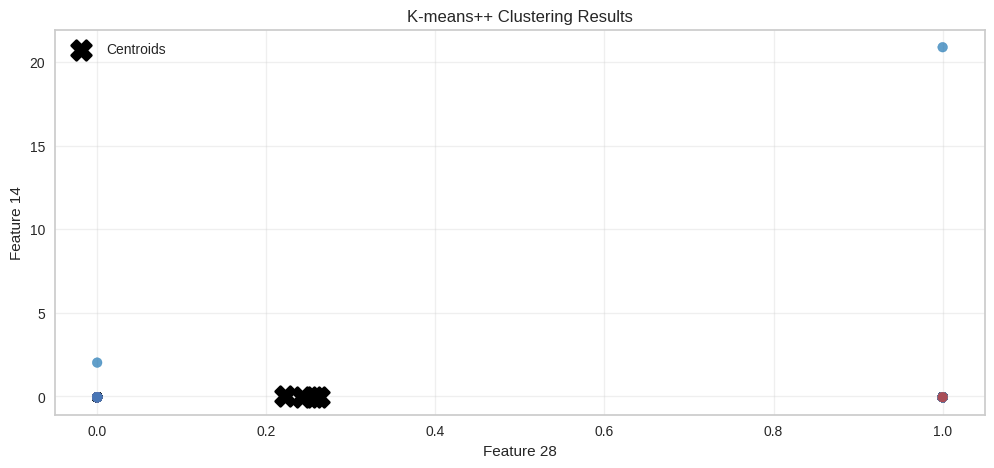

PCA: explained variation per principal component: [0.8  0.02 0.02 0.02]

Applying t-SNE...


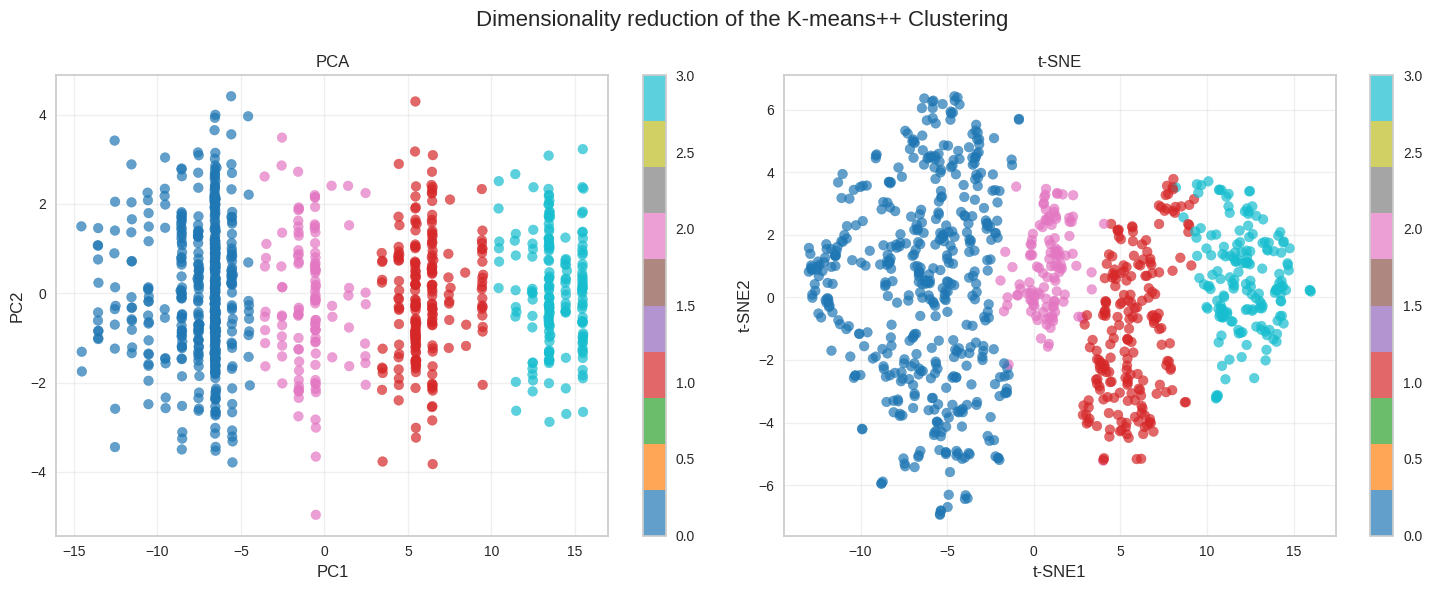

The intra-cluster distance of the clusters are:  [6.51 6.13 6.01 5.98]

All pair-wise inter-cluster distances:
 [[ 0.   13.59  6.59 21.32]
 [13.59  0.    7.02  7.75]
 [ 6.59  7.02  0.   14.75]
 [21.32  7.75 14.75  0.  ]]
Silhouette Score: 0.2892


In [ ]:
# Perform K-means++ Clustering using elbow method result
print("--- K-means++ Clustering with Elbow Method (After Outlier Removal) ---")
kmeansLabelsElbowOutlier, kmeansSilhouetteElbowOutlier = performKmeansPlusClustering(XOutlier, kMeansClustersOutlier)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(kmeansLabelsElbowOutlier, "K-means++ (Elbow Method - Clean Data)", originalTypeOutlier);

=== K-means++ (Elbow Method - Clean Data) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1  Cluster_2  Cluster_3
Type                                                           
Background Rural            45         21         10         26
Background Suburban         13          7          3          9
Background Urban           234         92         60         69
Industrial Suburban          3          0          1          0
Industrial Urban            18         15          5         12
Traffic Urban              147         68         39         53

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1  Cluster_2  Cluster_3
Type                                                           
Background Rural         44.12      20.59       9.80      25.49
Background Suburban      40.62      21.88       9.38      28.12
Background Urban         51.43      20.22      13.19      15.16
Industrial Suburban      75.00       0.00  

--- K-means++ Clustering with Silhouette Score (After Outlier Removal) ---
Initialization complete
Iteration 0, inertia 58503.80497225396.
Iteration 1, inertia 29257.298124531146.
Iteration 2, inertia 29244.056153567148.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 51288.13427675046.
Iteration 1, inertia 29266.36625144001.
Iteration 2, inertia 29244.056153567148.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 52743.174585542685.
Iteration 1, inertia 29969.353054933534.
Iteration 2, inertia 29253.996175451575.
Iteration 3, inertia 29244.390555419857.
Iteration 4, inertia 29244.056153567148.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 66933.04749533416.
Iteration 1, inertia 30383.272379658894.
Iteration 2, inertia 29264.386674547273.
Iteration 3, inertia 29253.996175451575.
Iteration 4, inertia 29244.390555419857.
Iteration 5, inertia 29244.056153567148

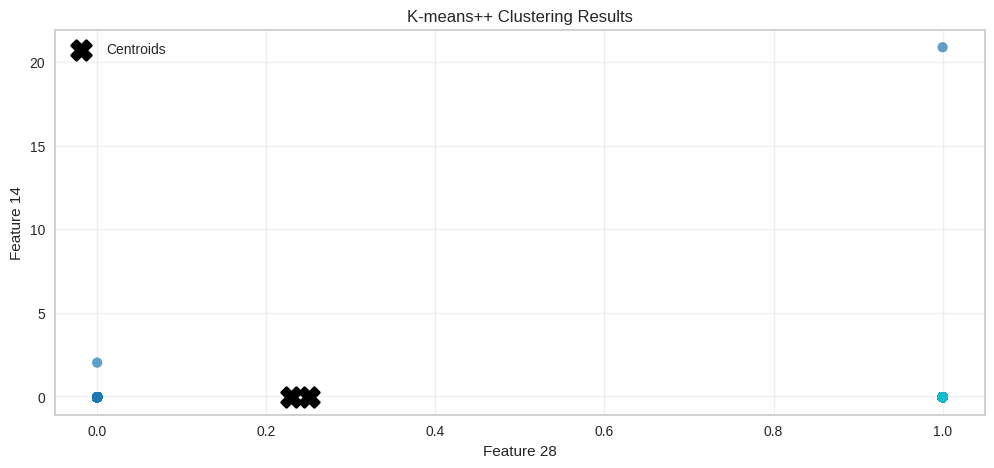

PCA: explained variation per principal component: [0.8  0.02]

Applying t-SNE...


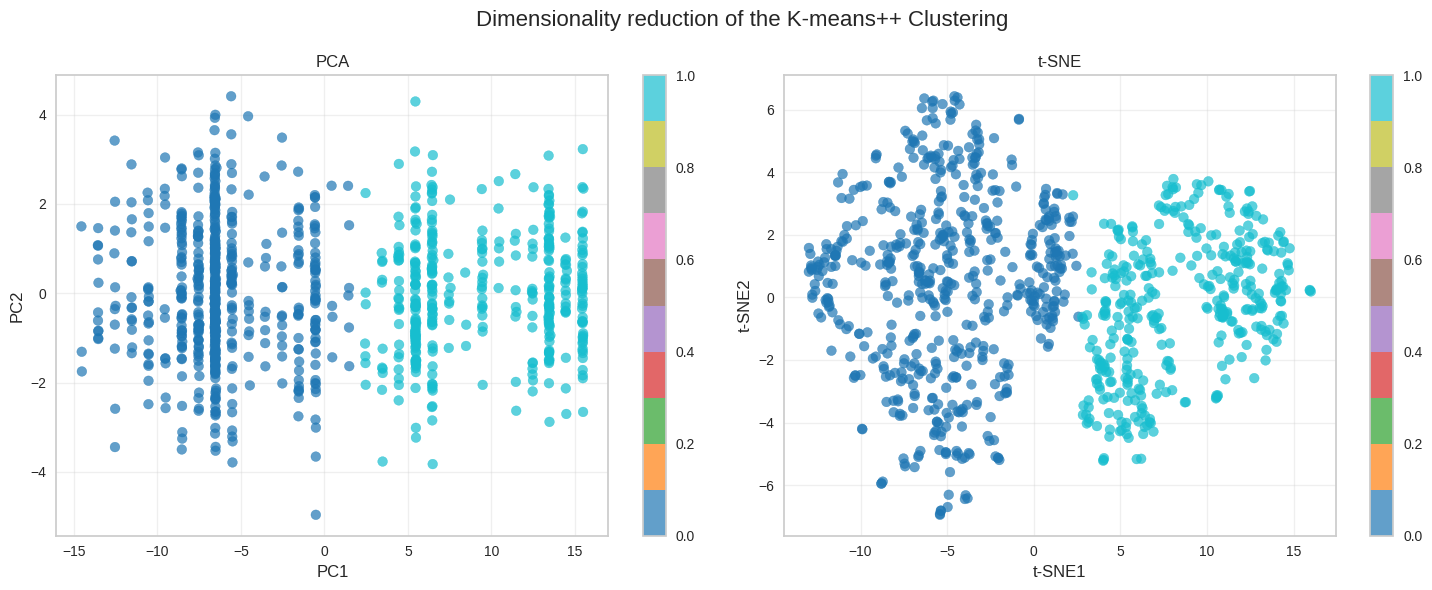

The intra-cluster distance of the clusters are:  [7.2  7.96]

All pair-wise inter-cluster distances:
 [[ 0.   15.73]
 [15.73  0.  ]]
Silhouette Score: 0.5370


In [ ]:
# Perform K-means++ Clustering using silhouette score result
print("--- K-means++ Clustering with Silhouette Score (After Outlier Removal) ---")
kmeansLabelsSilhouetteOutlier, kmeansSilhouetteSilhouetteOutlier = performKmeansPlusClustering(XOutlier, kMeansSilhouetteKOutlier)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(kmeansLabelsSilhouetteOutlier, "K-means++ (Silhouette Score - Clean Data)", originalTypeOutlier);

=== K-means++ (Silhouette Score - Clean Data) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural            55         47
Background Suburban         16         16
Background Urban           290        165
Industrial Suburban          4          0
Industrial Urban            23         27
Traffic Urban              183        124

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural         53.92      46.08
Background Suburban      50.00      50.00
Background Urban         63.74      36.26
Industrial Suburban     100.00       0.00
Industrial Urban         46.00      54.00
Traffic Urban            59.61      40.39

Chi-square test:
Chi-square statistic: 12.3261
P-value: 0.0306
Degrees of freedom: 5
There is a significant relationship between Type and clusters (p < 0.05)


## DBSCAN Clustering

--- Finding Optimal DBSCAN Parameters (After Outlier Removal) ---
Knee point found at eps = 5.6613


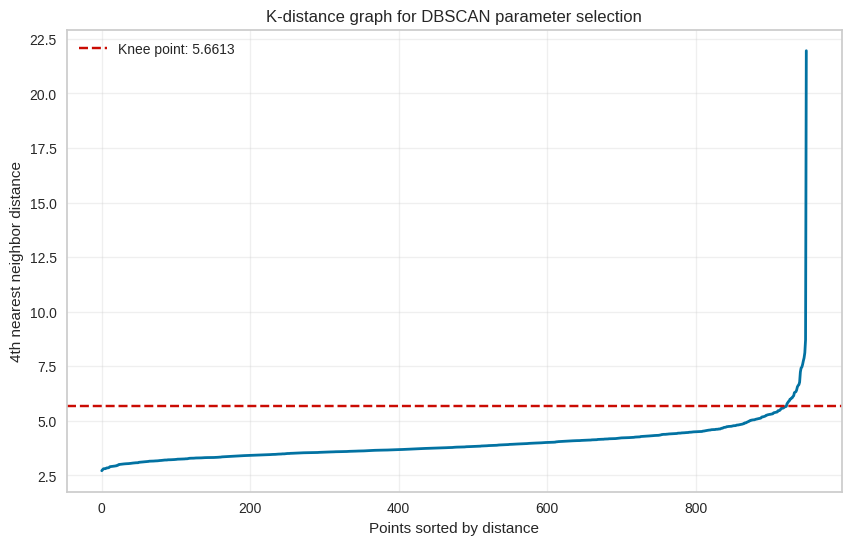

Testing DBSCAN parameters...

Top 10 parameter combinations:
         eps  min_samples  n_clusters  n_noise  silhouette_score
4   4.088692            5           2      187          0.279092
12  4.717722           17           2       81          0.241117
5   4.088692            7           3      210          0.238184
13  4.717722           19           2       86          0.235404
6   4.088692            9           3      224          0.226837
7   4.088692           11           3      252          0.206421
8   4.088692           13           3      278          0.189734
9   4.088692           15           3      301          0.169469
11  4.088692           19           3      388          0.125632
10  4.088692           17           4      359          0.029454

Best parameters: eps=4.0887, min_samples=5
Best silhouette score: 0.2791


In [ ]:
# Find optimal DBSCAN parameters
print("--- Finding Optimal DBSCAN Parameters (After Outlier Removal) ---")
optimalDbscanParamsOutlier, dbscanResultsOutlier = findOptimalDbscanParameters(XOutlier)


--- DBSCAN Clustering with Optimal Parameters (After Outlier Removal) ---
Estimated number of clusters: 2
Estimated number of noise points: 187


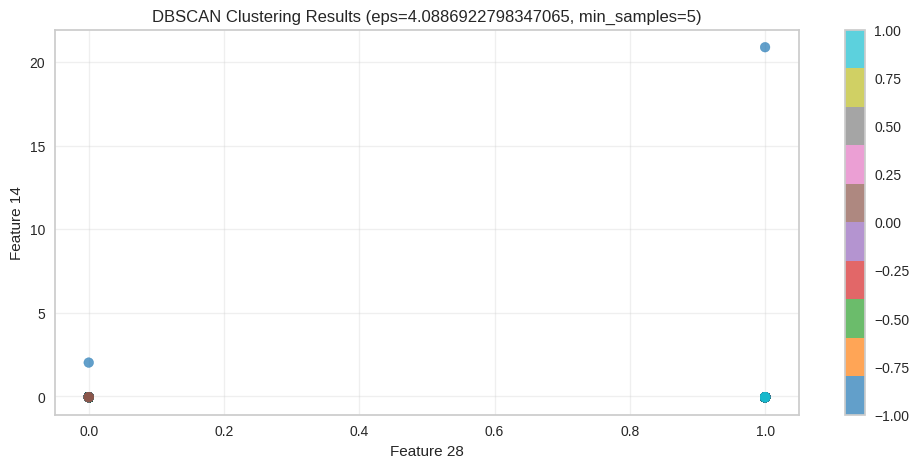

PCA: explained variation per principal component: [0.8  0.02]

Applying t-SNE...


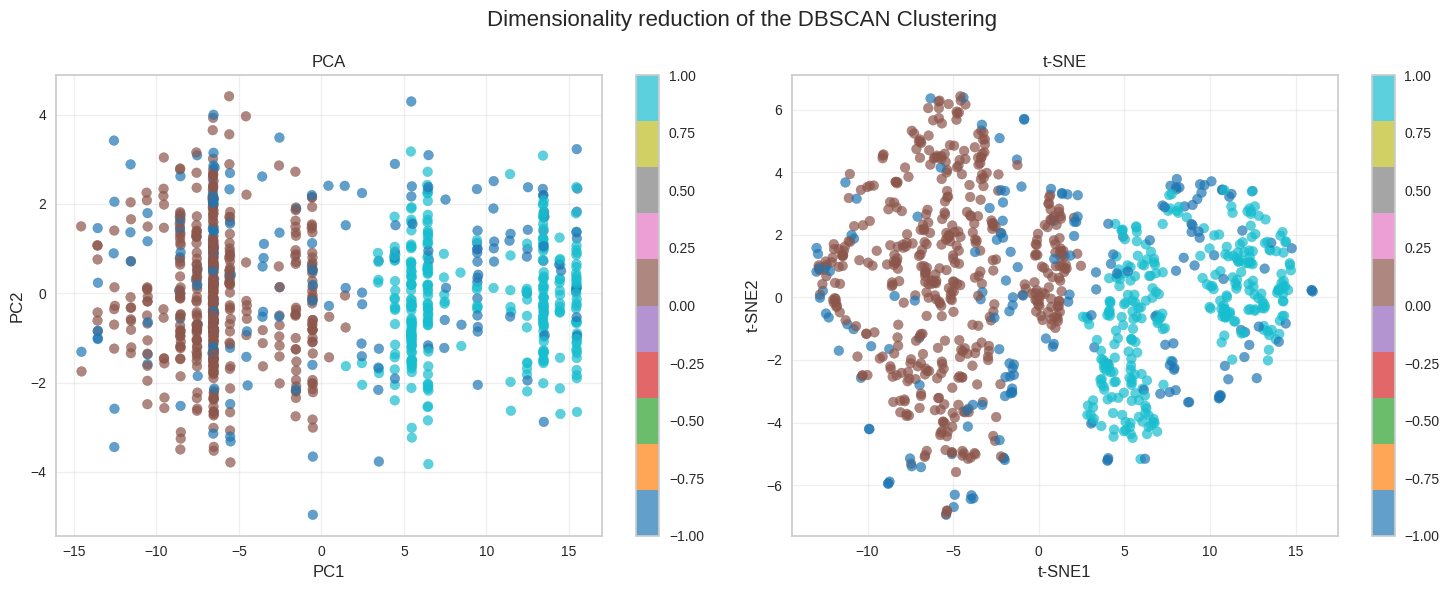

Silhouette Score (excluding noise): 0.5605


In [ ]:
# Perform DBSCAN with optimal parameters
print("\n--- DBSCAN Clustering with Optimal Parameters (After Outlier Removal) ---")
dbscanLabelsOutlier, dbscanNClustersOutlier, dbscanSilhouetteOutlier = performDbscanClustering(XOutlier, eps=optimalDbscanParamsOutlier[0], minSamples=optimalDbscanParamsOutlier[1])

In [ ]:
# Analyze relationship with Type variable
if dbscanNClustersOutlier > 0:
    analyzeTypeRelationship(dbscanLabelsOutlier, "DBSCAN Clustering (Clean Data)", originalTypeOutlier);

=== DBSCAN Clustering (Clean Data) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1  Noise
Type                                            
Background Rural            36         31     35
Background Suburban         14         14      4
Background Urban           241        128     86
Industrial Suburban          4          0      0
Industrial Urban            19         24      7
Traffic Urban              151        101     55

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1  Noise
Type                                            
Background Rural         35.29      30.39  34.31
Background Suburban      43.75      43.75  12.50
Background Urban         52.97      28.13  18.90
Industrial Suburban     100.00       0.00   0.00
Industrial Urban         38.00      48.00  14.00
Traffic Urban            49.19      32.90  17.92

Chi-square test:
Chi-square statistic: 32.0954
P-value: 0.0004
Degrees of freedom: 10
There is a 

## Result comparison

In [ ]:
# Create summary table of all clustering results after outlier removal
clusteringResultsOutlier = []

# Hierarchical (optimal - Silhouette)
clusteringResultsOutlier.append({
    'Method': 'Hierarchical (Optimal)',
    'Number of Clusters': hierarchicalNClustersOptimalOutlier,
    'Silhouette Score': hierarchicalSilhouetteOptimalOutlier,
    'Parameters': f'linkage=ward, n_clusters={hierarchicalClustersOutlier}'
})

# Hierarchical (distance)
clusteringResultsOutlier.append({
    'Method': 'Hierarchical (Distance)',
    'Number of Clusters': hierarchicalClusterDistanceOutlier,
    'Silhouette Score': hierarchicalSilhouetteDistanceOutlier,
    'Parameters': f'linkage=ward, distance=100'
})

# K-means++ (elbow)
clusteringResultsOutlier.append({
    'Method': 'K-means++ (Elbow)',
    'Number of Clusters': kMeansClustersOutlier,
    'Silhouette Score': kmeansSilhouetteElbowOutlier,
    'Parameters': f'n_clusters={kMeansClustersOutlier}, init=k-means++'
})

# K-means++ (silhouette)
clusteringResultsOutlier.append({
    'Method': 'K-means++ (Silhouette)',
    'Number of Clusters': kMeansSilhouetteKOutlier,
    'Silhouette Score': kmeansSilhouetteSilhouetteOutlier,
    'Parameters': f'n_clusters={kMeansSilhouetteKOutlier}, init=k-means++'
})

# DBSCAN
if dbscanNClustersOutlier > 0:
    clusteringResultsOutlier.append({
        'Method': 'DBSCAN',
        'Number of Clusters': dbscanNClustersOutlier,
        'Silhouette Score': dbscanSilhouetteOutlier,
        'Parameters': f'eps={optimalDbscanParamsOutlier[0]:.4f}, min_samples={optimalDbscanParamsOutlier[1]}'
    })

# Display results
resultsDFOutlier = pd.DataFrame(clusteringResultsOutlier)
print("\n=== CLUSTERING RESULTS SUMMARY (AFTER OUTLIER REMOVAL) ===")
print(resultsDFOutlier.to_string(index=False))


=== CLUSTERING RESULTS SUMMARY (AFTER OUTLIER REMOVAL) ===
                 Method  Number of Clusters  Silhouette Score                   Parameters
 Hierarchical (Optimal)                   2          0.534764   linkage=ward, n_clusters=2
Hierarchical (Distance)                   3          0.415641   linkage=ward, distance=100
      K-means++ (Elbow)                   4          0.289240 n_clusters=4, init=k-means++
 K-means++ (Silhouette)                   2          0.536957 n_clusters=2, init=k-means++
                 DBSCAN                   2          0.560478    eps=4.0887, min_samples=5


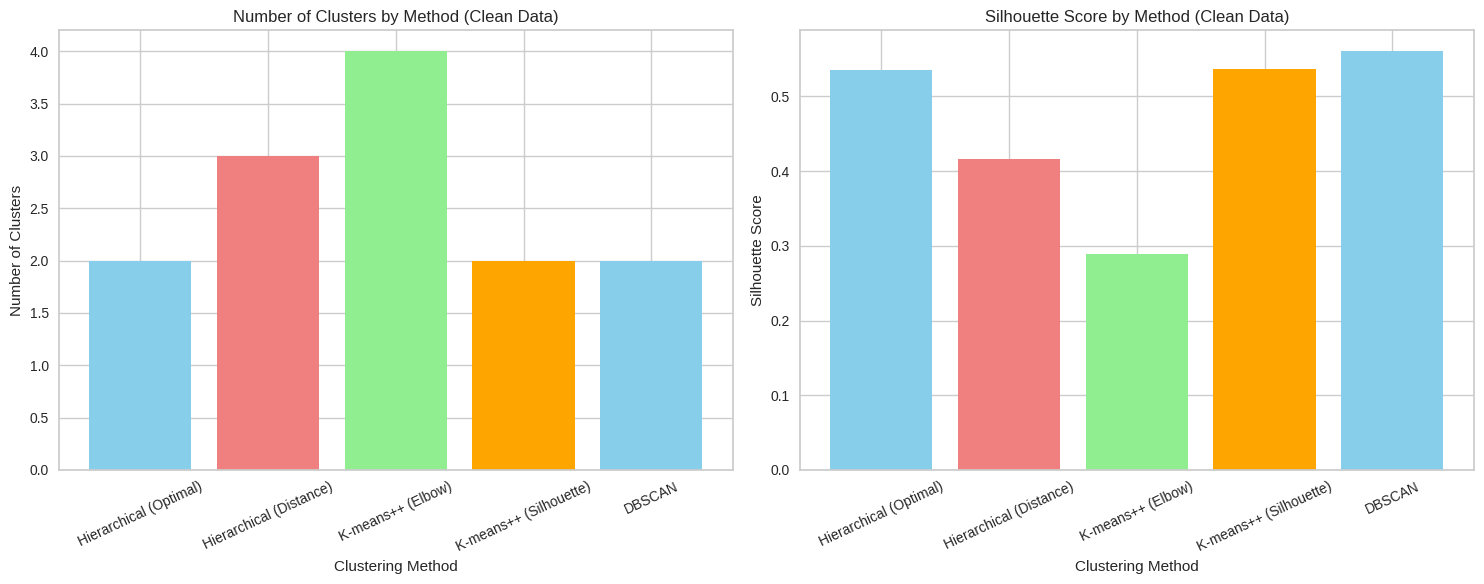

In [ ]:
# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Number of clusters comparison
methodsOutlier = resultsDFOutlier['Method']
nClustersOutlier = resultsDFOutlier['Number of Clusters']
silhouetteScoresOutlier = resultsDFOutlier['Silhouette Score']

ax1.bar(methodsOutlier, nClustersOutlier, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'][:len(methodsOutlier)])
ax1.set_xlabel('Clustering Method')
ax1.set_ylabel('Number of Clusters')
ax1.set_title('Number of Clusters by Method (Clean Data)')
ax1.tick_params(axis='x', rotation=25)

# Silhouette score comparison
ax2.bar(methodsOutlier, silhouetteScoresOutlier, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'][:len(methodsOutlier)])
ax2.set_xlabel('Clustering Method')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by Method (Clean Data)')
ax2.tick_params(axis='x', rotation=25)

plt.tight_layout()
plt.show()

In [ ]:
# Determine best method
bestMethodOutlier = resultsDFOutlier.loc[resultsDFOutlier['Silhouette Score'].idxmax()]
print(f"Best clustering method based on silhouette score (after outlier removal):")
print(f"Method: {bestMethodOutlier['Method']}")
print(f"Number of Clusters: {bestMethodOutlier['Number of Clusters']}")
print(f"Silhouette Score: {bestMethodOutlier['Silhouette Score']:.4f}")

Best clustering method based on silhouette score (after outlier removal):
Method: DBSCAN
Number of Clusters: 2
Silhouette Score: 0.5605


# CLUSTERING AFTER FEATURES REMOVAL

## Feature selection using ANOVA F-test

In [ ]:
def performFeatureSelectionAnova(X, y, kFeatures=None, alpha=0.05):
    """
    Perform feature selection using ANOVA F-test
    """
    print("=== FEATURE SELECTION USING ANOVA F-TEST ===")
    print(f"Original number of features: {X.shape[1]}")

    # Encode the target variable if it's categorical
    if y.dtype == 'object':
        labelEncoder = LabelEncoder()
        yEncoded = labelEncoder.fit_transform(y)
        print(f"Target variable encoded: {dict(zip(labelEncoder.classes_, labelEncoder.transform(labelEncoder.classes_)))}")
    else:
        yEncoded = y

    # Calculate F-statistics and p-values for all features
    fStatistics, pValues = f_classif(X, yEncoded)

    # Create a dataframe with feature importance
    featureImportance = pd.DataFrame({
        'Feature_Index': range(X.shape[1]),
        'F_Statistic': fStatistics,
        'P_Value': pValues,
        'Significant': pValues < alpha
    })

    # Sort by F-statistic (descending)
    featureImportance = featureImportance.sort_values('F_Statistic', ascending=False)

    print(f"\nTop 20 features by F-statistic:")
    print(featureImportance.head(20).to_string(index=False))

    # Count significant features
    nSignificantFeatures = np.sum(pValues < alpha)
    print(f"\nNumber of significant features (p < {alpha}): {nSignificantFeatures}")

    # Visualize feature importance
    plt.figure(figsize=(15, 10))

    # Plot 1: F-statistics
    plt.subplot(2, 2, 1)
    plt.bar(range(len(fStatistics)), np.sort(fStatistics)[::-1], color='skyblue', alpha=0.7)
    plt.xlabel('Feature Index (sorted by F-statistic)')
    plt.ylabel('F-statistic')
    plt.title('Feature Importance (F-statistics)')
    plt.grid(True, alpha=0.3)

    # Plot 2: P-values
    plt.subplot(2, 2, 2)
    plt.bar(range(len(pValues)), np.sort(pValues), color='lightcoral', alpha=0.7)
    plt.axhline(y=alpha, color='red', linestyle='--', label=f'α = {alpha}')
    plt.xlabel('Feature Index (sorted by p-value)')
    plt.ylabel('P-value')
    plt.title('Feature Significance (P-values)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Significant vs Non-significant
    plt.subplot(2, 2, 3)
    significantCounts = [nSignificantFeatures, X.shape[1] - nSignificantFeatures]
    labels = ['Significant', 'Non-significant']
    colors = ['lightgreen', 'lightcoral']
    plt.pie(significantCounts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Feature Significance Distribution')

    # Plot 4: Feature selection visualization
    plt.subplot(2, 2, 4)
    selectedFeatures = featureImportance['Feature_Index'].head(nSignificantFeatures).values
    colors = ['green' if i in selectedFeatures else 'red' for i in range(X.shape[1])]
    plt.scatter(range(X.shape[1]), fStatistics, c=colors, alpha=0.7)
    plt.xlabel('Feature Index')
    plt.ylabel('F-statistic')
    plt.title('Selected Features (green=selected, red=removed)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Determine number of features to keep
    if kFeatures is None:
        kFeatures = nSignificantFeatures

    if kFeatures == 0:
        print("Warning: No significant features found. Using top 5 features.")
        kFeatures = min(5, X.shape[1])

    print(f"\nSelecting top {kFeatures} features")

    # Select top k features
    selector = SelectKBest(score_func=f_classif, k=kFeatures)
    XReduced = selector.fit_transform(X, yEncoded)

    # Get selected feature indices
    selectedFeatureIndices = selector.get_support(indices=True)
    selectedFeatureScores = selector.scores_

    print(f"Selected feature indices: {selectedFeatureIndices}")
    print(f"Selected feature F-statistics: {selectedFeatureScores.round(4)}")
    print(f"Reduced dataset shape: {XReduced.shape}")
    print(f"Dimensionality reduction: {X.shape[1]} -> {XReduced.shape[1]} ({(1 - XReduced.shape[1]/X.shape[1])*100:.1f}% reduction)")

    return XReduced, selectedFeatureIndices, featureImportance

=== FEATURE SELECTION USING ANOVA F-TEST ===
Original number of features: 35
Target variable encoded: {'Background Rural': np.int64(0), 'Background Suburban': np.int64(1), 'Background Urban': np.int64(2), 'Industrial Suburban': np.int64(3), 'Industrial Urban': np.int64(4), 'Traffic Urban': np.int64(5)}

Top 20 features by F-statistic:
 Feature_Index  F_Statistic      P_Value  Significant
            15    12.746403 5.001269e-12         True
            10    11.773077 4.440055e-11         True
            13    11.332377 1.193848e-10         True
            12     9.984880 2.456353e-09         True
            14     7.467404 6.853485e-07         True
            16     4.077491 1.140469e-03         True
             8     3.958380 1.468009e-03         True
            24     2.297123 4.337242e-02         True
             3     2.119374 6.091405e-02        False
            17     1.841274 1.021788e-01        False
             0     1.785136 1.131515e-01        False
            25 

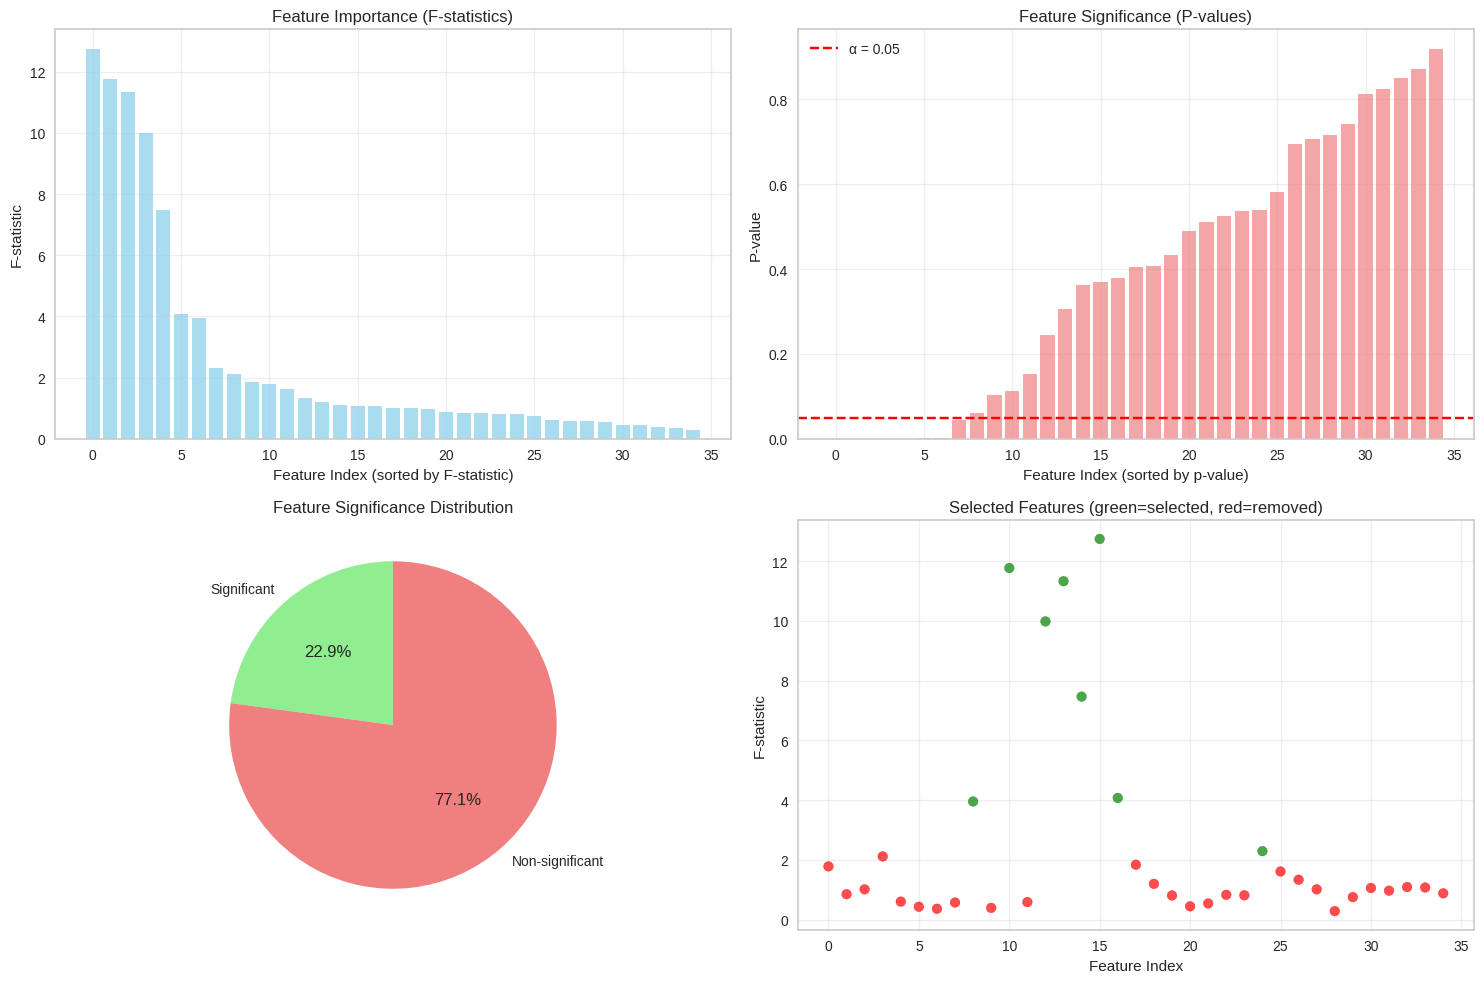


Selecting top 8 features
Selected feature indices: [ 8 10 12 13 14 15 16 24]
Selected feature F-statistics: [ 1.7851  0.855   1.0183  2.1194  0.6057  0.4348  0.3668  0.5774  3.9584
  0.3967 11.7731  0.5911  9.9849 11.3324  7.4674 12.7464  4.0775  1.8413
  1.2009  0.8136  0.4493  0.5441  0.8336  0.8185  2.2971  1.615   1.3396
  1.0168  0.2885  0.7567  1.0628  0.972   1.0937  1.0789  0.8845]
Reduced dataset shape: (1000, 8)
Dimensionality reduction: 35 -> 8 (77.1% reduction)


In [ ]:
# Perform feature selection
XReduced, selectedFeatureIndices, featureImportanceResults = performFeatureSelectionAnova(X, originalType)

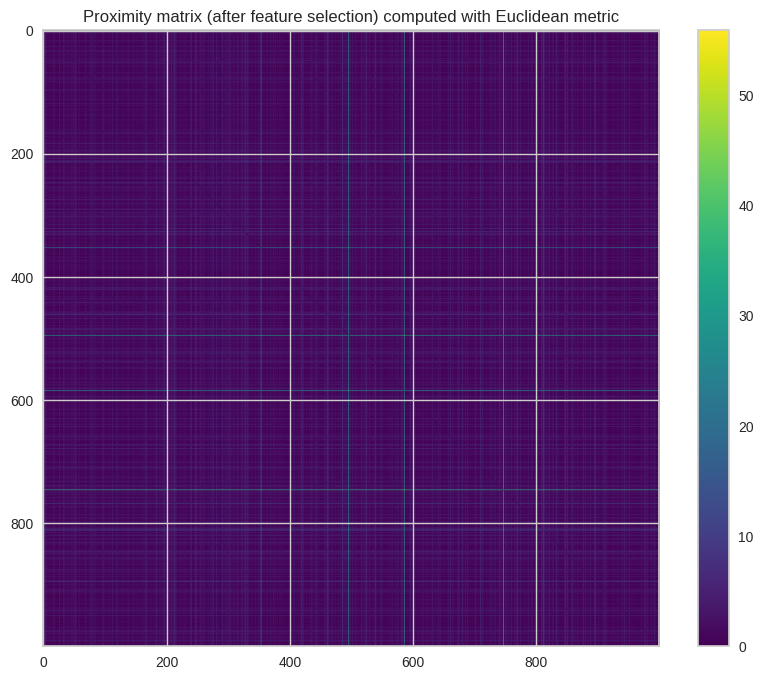

In [ ]:
# Visualize the reduced dataset using proximity matrix
numericalDataReduced = XReduced
PMReduced = pdist(numericalDataReduced, metric='euclidean')
PMReduced = squareform(PMReduced).round(2)

# Plot the proximity matrix for reduced data
plt.figure(figsize=(10, 8))
plt.imshow(PMReduced, cmap='viridis')
plt.title('Proximity matrix (after feature selection) computed with Euclidean metric')
plt.colorbar()
plt.show()

In [ ]:
print(f"Reduced dataset info:")
print(f"Shape: {XReduced.shape}")

Reduced dataset info:
Shape: (1000, 8)


## Hierarchical Clustering

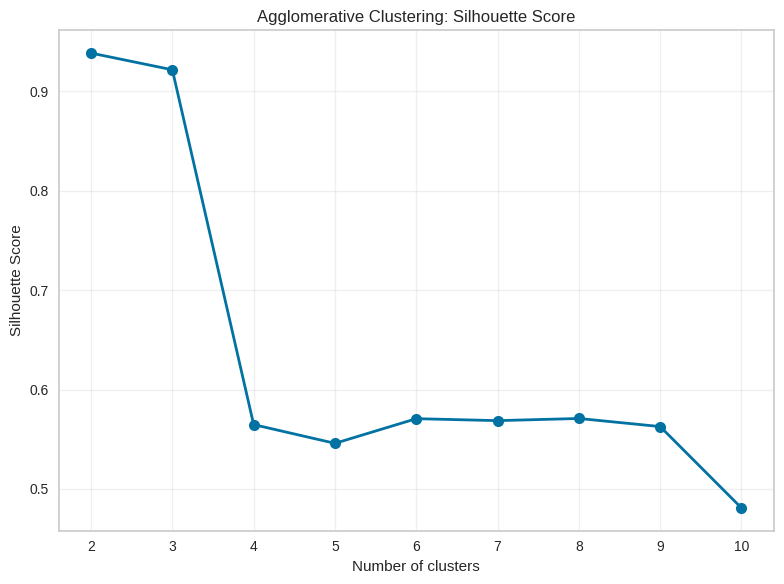

Optimal number of clusters based on silhouette score: 2
Max silhouette score: 0.9385


In [ ]:
# Find optimal number of clusters using silhouette score
hierarchicalClustersReduced, hierarchicalSilhouetteScoresReduced = findOptimalClustersHierarchical(XReduced, maxClusters=10)

--- Hierarchical Clustering with Distance Criterion (After Feature Selection) ---


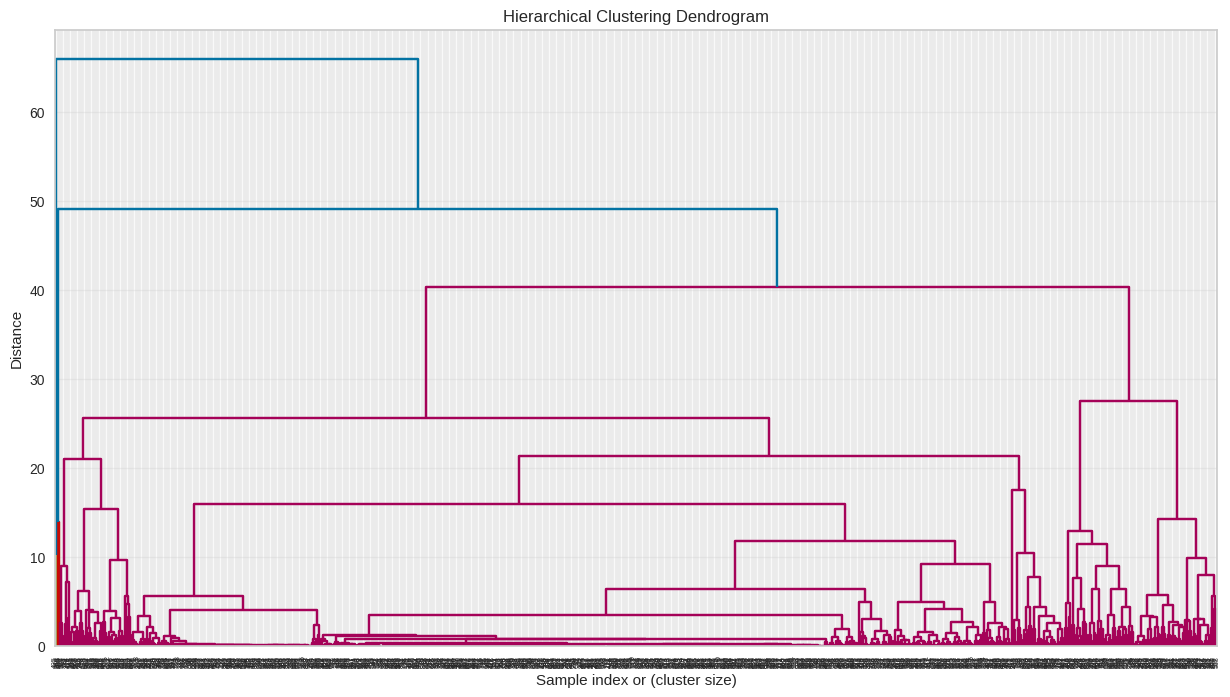

Hierarchical clustering produced 3 clusters
3 centroids are being computed, as we have 3 clusters.
The centroid of cluster 0 has coordinates:  12.13 -20.11 -22.03 0.67 -6.94 -0.12 -0.16 0.5
The centroid of cluster 1 has coordinates:  -12.87 1.25 0.02 -0.38 20.88 0.25 0.2 0.0
The centroid of cluster 2 has coordinates:  0.0 0.04 0.04 -0.0 -0.03 -0.0 -0.0 0.24
The intra-cluster distance of the clusters are:  [10.25 13.96  1.97]

All pair-wise inter-cluster distances:
 [[ 0.   48.4  32.99]
 [48.4   0.   24.59]
 [32.99 24.59  0.  ]]
Silhouette Score: 0.9217


In [ ]:
# Perform Hierarchical Clustering using distance criterion
print("--- Hierarchical Clustering with Distance Criterion (After Feature Selection) ---")
hierarchicalLabelsDistanceReduced, hierarchicalClusterDistanceReduced, hierarchicalSilhouetteDistanceReduced = performHierarchicalClustering(XReduced, maxDistance=45)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(hierarchicalLabelsDistanceReduced, "Hierarchical Clustering (Reduced Features)", originalType);

=== Hierarchical Clustering (Reduced Features) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1  Cluster_2
Type                                                
Background Rural             0          0        112
Background Suburban          2          0         40
Background Urban             0          0        476
Industrial Suburban          0          0          4
Industrial Urban             0          2         51
Traffic Urban                0          0        313

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1  Cluster_2
Type                                                
Background Rural          0.00       0.00     100.00
Background Suburban       4.76       0.00      95.24
Background Urban          0.00       0.00     100.00
Industrial Suburban       0.00       0.00     100.00
Industrial Urban          0.00       3.77      96.23
Traffic Urban             0.00       0.00     100.00

Chi-square test:
Chi-

--- Hierarchical Clustering with Optimal Number of Clusters (After Feature Selection) ---


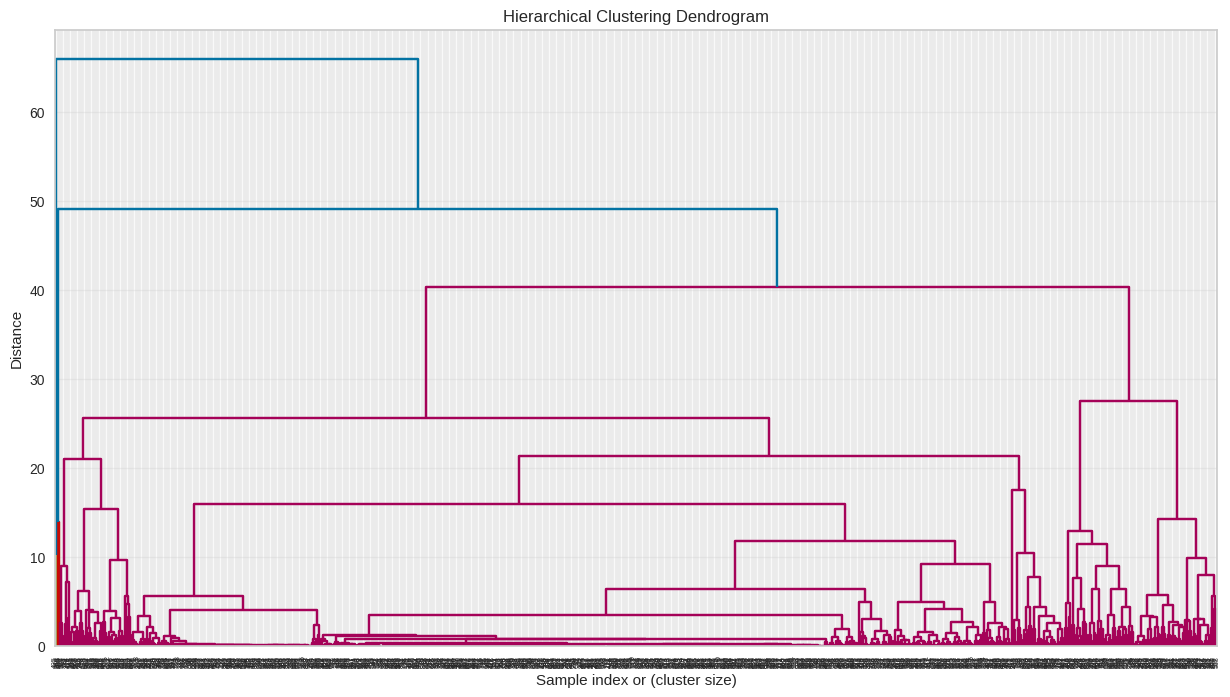

Hierarchical clustering produced 2 clusters
2 centroids are being computed, as we have 2 clusters.
The centroid of cluster 0 has coordinates:  12.13 -20.11 -22.03 0.67 -6.94 -0.12 -0.16 0.5
The centroid of cluster 1 has coordinates:  -0.02 0.04 0.04 -0.0 0.01 0.0 0.0 0.24
The intra-cluster distance of the clusters are:  [10.25  2.06]

All pair-wise inter-cluster distances:
 [[ 0.   33.01]
 [33.01  0.  ]]
Silhouette Score: 0.9385


In [ ]:
# Perform Hierarchical Clustering using optimal number of clusters
print("--- Hierarchical Clustering with Optimal Number of Clusters (After Feature Selection) ---")
hierarchicalLabelsOptimalReduced, hierarchicalNClustersOptimalReduced, hierarchicalSilhouetteOptimalReduced = performHierarchicalClustering(XReduced, targetClusters=hierarchicalClustersReduced)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(hierarchicalLabelsOptimalReduced, "Hierarchical Clustering (Reduced Features)", originalType);

=== Hierarchical Clustering (Reduced Features) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural             0        112
Background Suburban          2         40
Background Urban             0        476
Industrial Suburban          0          4
Industrial Urban             0         53
Traffic Urban                0        313

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural          0.00     100.00
Background Suburban       4.76      95.24
Background Urban          0.00     100.00
Industrial Suburban       0.00     100.00
Industrial Urban          0.00     100.00
Traffic Urban             0.00     100.00

Chi-square test:
Chi-square statistic: 45.7105
P-value: 0.0000
Degrees of freedom: 5
There is a significant relationship between Type and clusters (p < 0.05)


## K-means++ Clustering

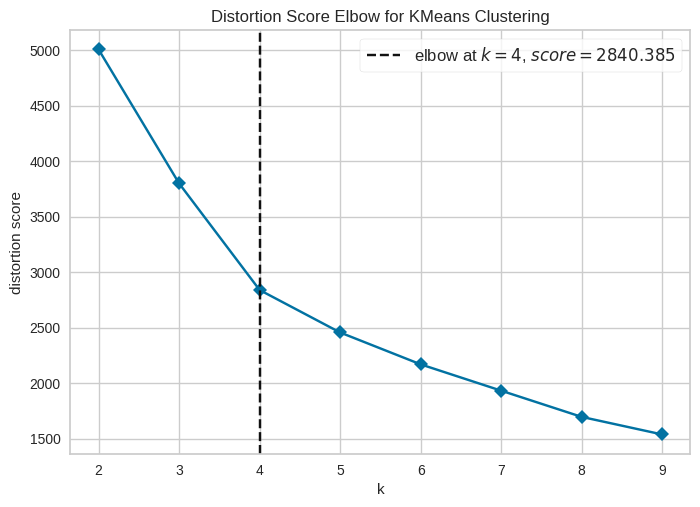

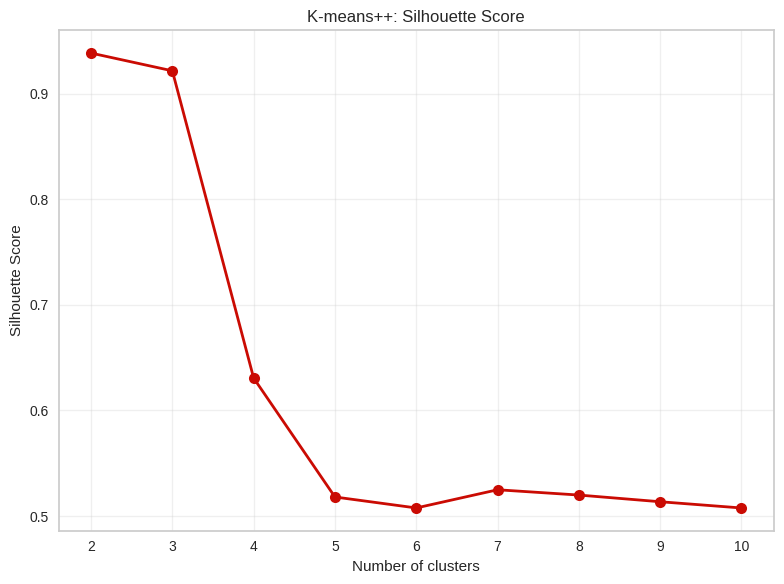

Optimal number of clusters based on elbow (inertia): 4
Optimal number of clusters based on silhouette score: 2
Max silhouette score: 0.9385


In [ ]:
# Find optimal number of clusters using both elbow method and silhouette score
kMeansClustersReduced, kMeansSilhouetteKReduced, kMeansSilhouetteScoresReduced = findOptimalClustersKmeans(XReduced, maxClusters=10)

--- K-means++ Clustering with Elbow Method (After Feature Selection) ---
Initialization complete
Iteration 0, inertia 4176.201922733799.
Iteration 1, inertia 3423.8024782796106.
Iteration 2, inertia 3313.9175296700023.
Iteration 3, inertia 2935.4580949545348.
Iteration 4, inertia 2854.9791275231546.
Iteration 5, inertia 2844.1787271116045.
Iteration 6, inertia 2841.93771250731.
Iteration 7, inertia 2841.6792663844067.
Iteration 8, inertia 2841.6078880946657.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 4372.98526805022.
Iteration 1, inertia 2914.331803913458.
Iteration 2, inertia 2858.043987275621.
Iteration 3, inertia 2847.1094336434435.
Iteration 4, inertia 2843.163183557835.
Iteration 5, inertia 2842.0401231521405.
Iteration 6, inertia 2841.8949578740235.
Iteration 7, inertia 2841.836572012679.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 3705.0797596865855.
Iteration 1, inertia 2905.10454299

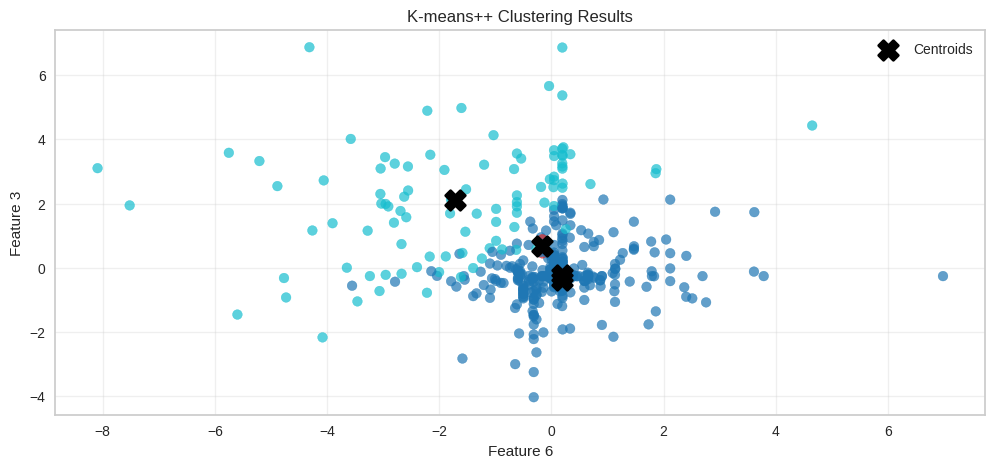

PCA: explained variation per principal component: [0.38 0.19 0.14 0.12]

Applying t-SNE...


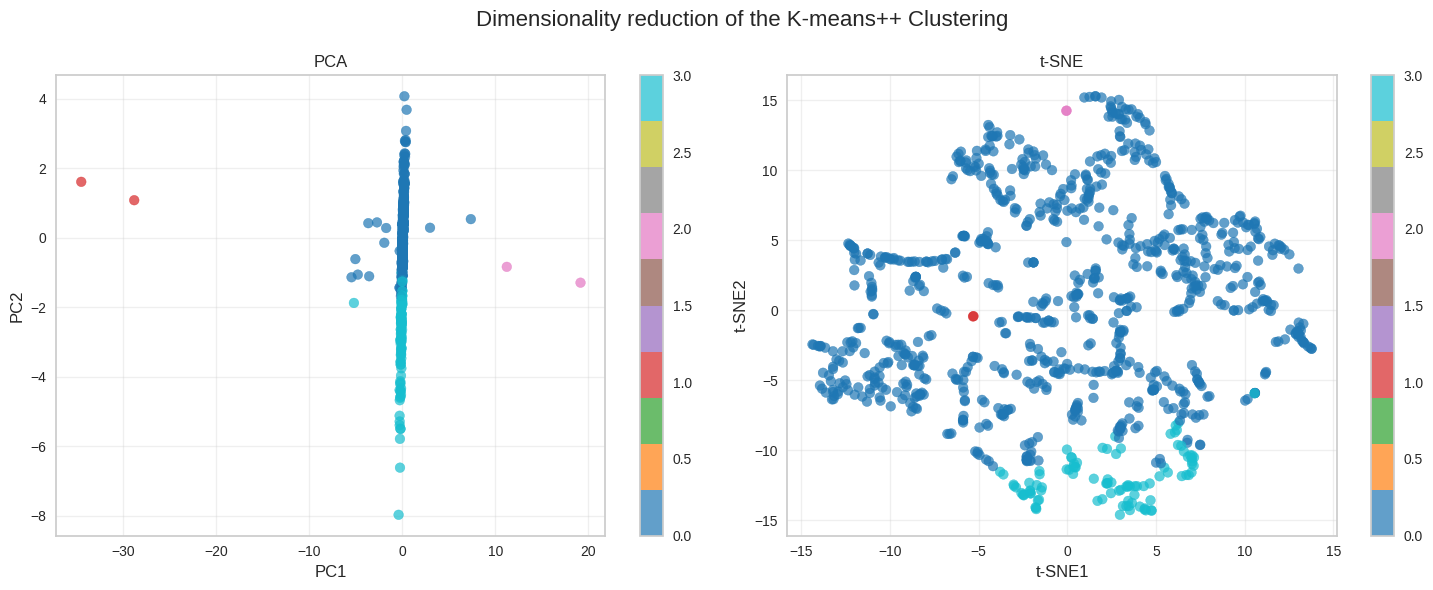

The intra-cluster distance of the clusters are:  [ 1.41 10.25 13.96  3.82]

All pair-wise inter-cluster distances:
 [[ 0.   33.   24.58  3.3 ]
 [33.    0.   48.4  33.04]
 [24.58 48.4   0.   24.84]
 [ 3.3  33.04 24.84  0.  ]]
Silhouette Score: 0.6307


In [ ]:
# Perform K-means++ Clustering using elbow method result
print("--- K-means++ Clustering with Elbow Method (After Feature Selection) ---")
kmeansLabelsElbowReduced, kmeansSilhouetteElbowReduced = performKmeansPlusClustering(XReduced, kMeansClustersReduced)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(kmeansLabelsElbowReduced, "K-means++ (Elbow Method - Reduced Features)", originalType);

=== K-means++ (Elbow Method - Reduced Features) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1  Cluster_2  Cluster_3
Type                                                           
Background Rural            90          0          0         22
Background Suburban         37          2          0          3
Background Urban           414          0          0         62
Industrial Suburban          4          0          0          0
Industrial Urban            45          0          2          6
Traffic Urban              308          0          0          5

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1  Cluster_2  Cluster_3
Type                                                           
Background Rural         80.36       0.00       0.00      19.64
Background Suburban      88.10       4.76       0.00       7.14
Background Urban         86.97       0.00       0.00      13.03
Industrial Suburban     100.00       

--- K-means++ Clustering with Silhouette Score (After Feature Selection) ---
Initialization complete
Iteration 0, inertia 5810.894758401591.
Iteration 1, inertia 5007.5498998818875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6543.59502924356.
Iteration 1, inertia 5901.442673772807.
Iteration 2, inertia 5708.11421224569.
Iteration 3, inertia 5007.5498998818875.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 7172.959242988541.
Iteration 1, inertia 6872.2330958531575.
Iteration 2, inertia 6870.122941654707.
Iteration 3, inertia 6866.815750397118.
Iteration 4, inertia 6865.487279867862.
Iteration 5, inertia 6865.4364273249585.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 7156.745149106864.
Iteration 1, inertia 6912.065999146971.
Iteration 2, inertia 6885.914814694692.
Iteration 3, inertia 6881.267231066674.
Iteration 4, inertia 6880.872114336119.
Iterati

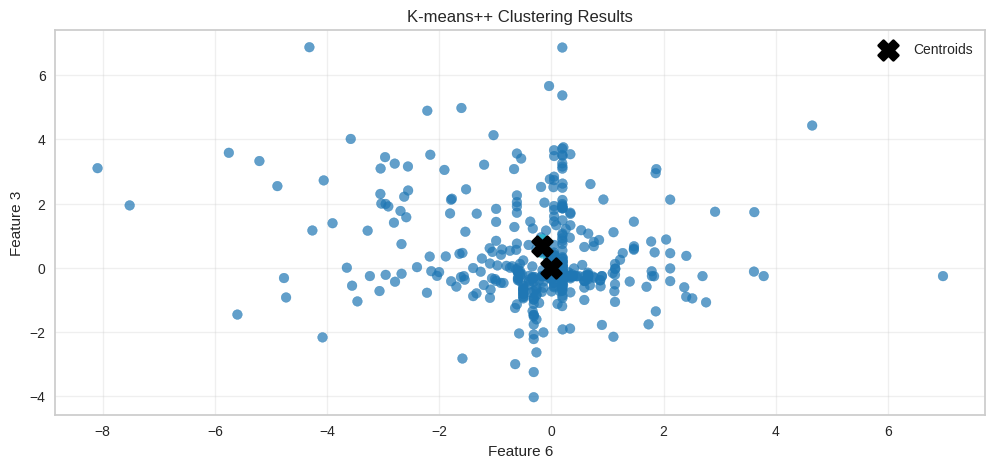

PCA: explained variation per principal component: [0.38 0.19]

Applying t-SNE...


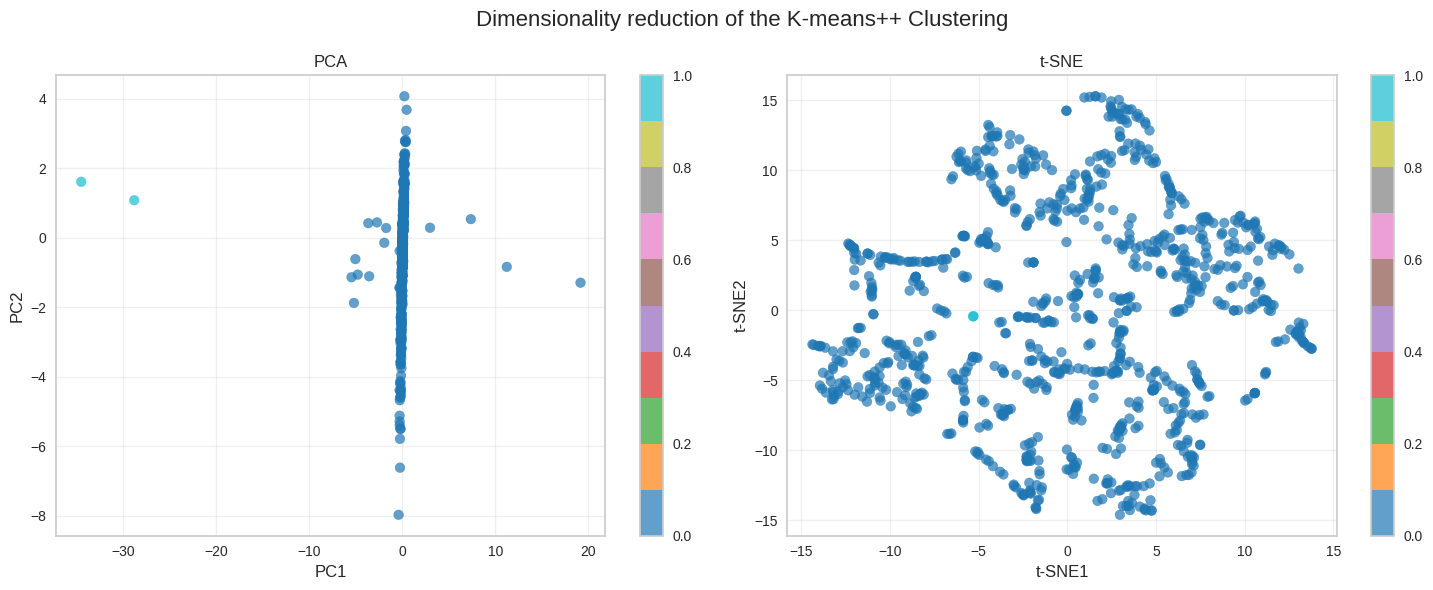

The intra-cluster distance of the clusters are:  [ 2.06 10.25]

All pair-wise inter-cluster distances:
 [[ 0.   33.01]
 [33.01  0.  ]]
Silhouette Score: 0.9385


In [ ]:
# Perform K-means++ Clustering using silhouette score result
print("--- K-means++ Clustering with Silhouette Score (After Feature Selection) ---")
kmeansLabelsSilhouetteReduced, kmeansSilhouetteSilhouetteReduced = performKmeansPlusClustering(XReduced, kMeansSilhouetteKReduced)

In [ ]:
# Analyze relationship with Type variable
analyzeTypeRelationship(kmeansLabelsSilhouetteReduced, "K-means++ (Silhouette Score - Reduced Features)", originalType);

=== K-means++ (Silhouette Score - Reduced Features) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural           112          0
Background Suburban         40          2
Background Urban           476          0
Industrial Suburban          4          0
Industrial Urban            53          0
Traffic Urban              313          0

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1
Type                                     
Background Rural        100.00       0.00
Background Suburban      95.24       4.76
Background Urban        100.00       0.00
Industrial Suburban     100.00       0.00
Industrial Urban        100.00       0.00
Traffic Urban           100.00       0.00

Chi-square test:
Chi-square statistic: 45.7105
P-value: 0.0000
Degrees of freedom: 5
There is a significant relationship between Type and clusters (p < 0.05)


## DBSCAN Clustering

--- Finding Optimal DBSCAN Parameters (After Feature Selection) ---
Knee point found at eps = 2.7356


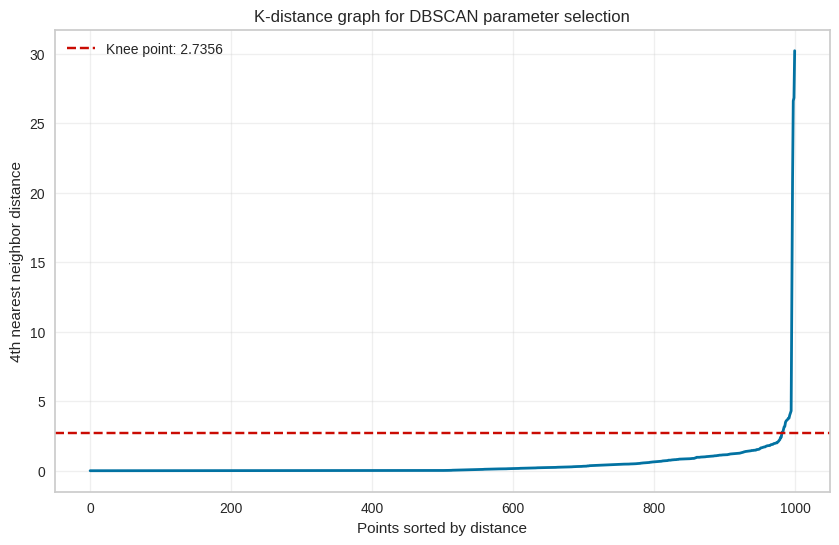

Testing DBSCAN parameters...

Top 10 parameter combinations:
         eps  min_samples  n_clusters  n_noise  silhouette_score
8   3.495531            3           2        5          0.764334
9   3.799491            3           2        5          0.764334
10  4.103450            5           2        5          0.764334
6   2.887613            3           2       12          0.763368
7   3.191572            3           2       11          0.763276
5   2.583654            3           2       13          0.762819
0   1.367817            3           2       37          0.754470
1   1.367817            7           2       59          0.602572
3   1.975735            3           3       15          0.567499
4   2.279694            3           3       14          0.566963

Best parameters: eps=3.4955, min_samples=3
Best silhouette score: 0.7643


In [ ]:
# Find optimal DBSCAN parameters
print("--- Finding Optimal DBSCAN Parameters (After Feature Selection) ---")
optimalDbscanParamsReduced, dbscanResultsReduced = findOptimalDbscanParameters(XReduced)


--- DBSCAN Clustering with Optimal Parameters (After Feature Selection) ---
Estimated number of clusters: 2
Estimated number of noise points: 5


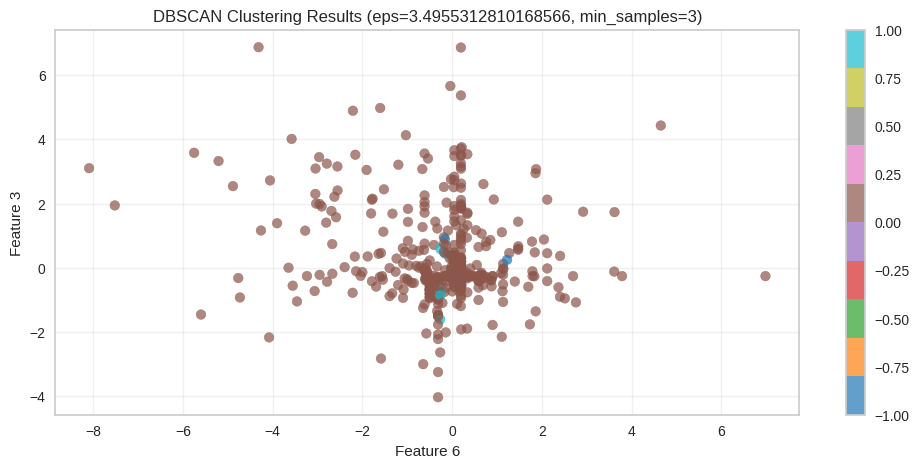

PCA: explained variation per principal component: [0.38 0.19]

Applying t-SNE...


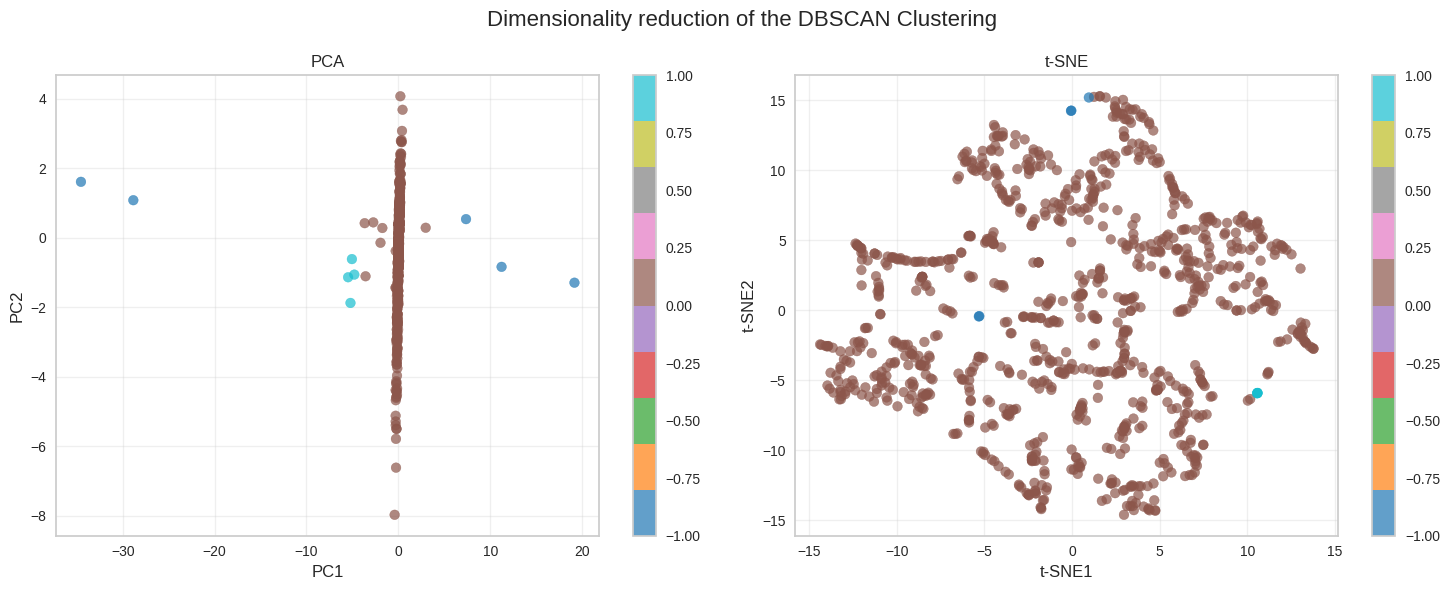

Silhouette Score (excluding noise): 0.7697


In [ ]:
# Perform DBSCAN with optimal parameters
print("\n--- DBSCAN Clustering with Optimal Parameters (After Feature Selection) ---")
dbscanLabelsReduced, dbscanNClustersReduced, dbscanSilhouetteReduced = performDbscanClustering(XReduced, eps=optimalDbscanParamsReduced[0], minSamples=optimalDbscanParamsReduced[1])

In [ ]:
# Analyze relationship with Type variable
if dbscanNClustersReduced > 0:
    analyzeTypeRelationship(dbscanLabelsReduced, "DBSCAN Clustering (Reduced Features)", originalType);

=== DBSCAN Clustering (Reduced Features) vs Type Analysis ===
Contingency Table:
col_0                Cluster_0  Cluster_1  Noise
Type                                            
Background Rural           108          4      0
Background Suburban         39          0      3
Background Urban           476          0      0
Industrial Suburban          4          0      0
Industrial Urban            51          0      2
Traffic Urban              313          0      0

Percentage distribution within each Type:
col_0                Cluster_0  Cluster_1  Noise
Type                                            
Background Rural         96.43       3.57   0.00
Background Suburban      92.86       0.00   7.14
Background Urban        100.00       0.00   0.00
Industrial Suburban     100.00       0.00   0.00
Industrial Urban         96.23       0.00   3.77
Traffic Urban           100.00       0.00   0.00

Chi-square test:
Chi-square statistic: 85.0206
P-value: 0.0000
Degrees of freedom: 10
There

## Result comparison

In [ ]:
# Create summary table of all clustering results after feature selection
clusteringResultsReduced = []

# Hierarchical (optimal - Silhouette)
clusteringResultsReduced.append({
    'Method': 'Hierarchical (Optimal)',
    'Number of Clusters': hierarchicalNClustersOptimalReduced,
    'Silhouette Score': hierarchicalSilhouetteOptimalReduced,
    'Parameters': f'linkage=ward, n_clusters={hierarchicalClustersReduced}'
})

# Hierarchical (distance)
clusteringResultsReduced.append({
    'Method': 'Hierarchical (Distance)',
    'Number of Clusters': hierarchicalClusterDistanceReduced,
    'Silhouette Score': hierarchicalSilhouetteDistanceReduced,
    'Parameters': f'linkage=ward, distance=100'
})

# K-means++ (elbow)
clusteringResultsReduced.append({
    'Method': 'K-means++ (Elbow)',
    'Number of Clusters': kMeansClustersReduced,
    'Silhouette Score': kmeansSilhouetteElbowReduced,
    'Parameters': f'n_clusters={kMeansClustersReduced}, init=k-means++'
})

# K-means++ (silhouette)
clusteringResultsReduced.append({
    'Method': 'K-means++ (Silhouette)',
    'Number of Clusters': kMeansSilhouetteKReduced,
    'Silhouette Score': kmeansSilhouetteSilhouetteReduced,
    'Parameters': f'n_clusters={kMeansSilhouetteKReduced}, init=k-means++'
})

# DBSCAN
if dbscanNClustersReduced > 0:
    clusteringResultsReduced.append({
        'Method': 'DBSCAN',
        'Number of Clusters': dbscanNClustersReduced,
        'Silhouette Score': dbscanSilhouetteReduced,
        'Parameters': f'eps={optimalDbscanParamsReduced[0]:.4f}, min_samples={optimalDbscanParamsReduced[1]}'
    })

# Display results
resultsDFReduced = pd.DataFrame(clusteringResultsReduced)
print("\n=== CLUSTERING RESULTS SUMMARY (AFTER FEATURE SELECTION) ===")
print(resultsDFReduced.to_string(index=False))


=== CLUSTERING RESULTS SUMMARY (AFTER FEATURE SELECTION) ===
                 Method  Number of Clusters  Silhouette Score                   Parameters
 Hierarchical (Optimal)                   2          0.938498   linkage=ward, n_clusters=2
Hierarchical (Distance)                   3          0.921686   linkage=ward, distance=100
      K-means++ (Elbow)                   4          0.630681 n_clusters=4, init=k-means++
 K-means++ (Silhouette)                   2          0.938498 n_clusters=2, init=k-means++
                 DBSCAN                   2          0.769739    eps=3.4955, min_samples=3


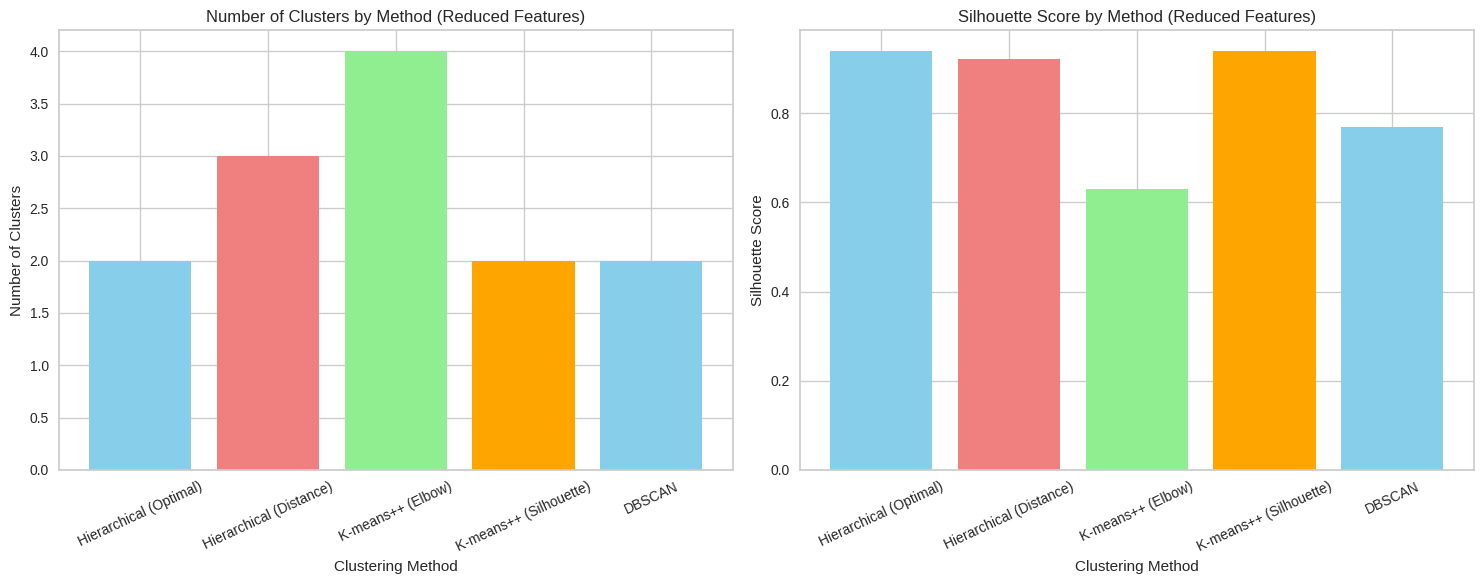

In [ ]:
# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Number of clusters comparison
methodsReduced = resultsDFReduced['Method']
nClustersReduced = resultsDFReduced['Number of Clusters']
silhouetteScoresReduced = resultsDFReduced['Silhouette Score']

ax1.bar(methodsReduced, nClustersReduced, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'][:len(methodsReduced)])
ax1.set_xlabel('Clustering Method')
ax1.set_ylabel('Number of Clusters')
ax1.set_title('Number of Clusters by Method (Reduced Features)')
ax1.tick_params(axis='x', rotation=25)

# Silhouette score comparison
ax2.bar(methodsReduced, silhouetteScoresReduced, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'][:len(methodsReduced)])
ax2.set_xlabel('Clustering Method')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by Method (Reduced Features)')
ax2.tick_params(axis='x', rotation=25)

plt.tight_layout()
plt.show()

In [ ]:
# Determine best method
bestMethodReduced = resultsDFReduced.loc[resultsDFReduced['Silhouette Score'].idxmax()]
print(f"Best clustering method based on silhouette score (after feature selection):")
print(f"Method: {bestMethodReduced['Method']}")
print(f"Number of Clusters: {bestMethodReduced['Number of Clusters']}")
print(f"Silhouette Score: {bestMethodReduced['Silhouette Score']:.4f}")

Best clustering method based on silhouette score (after feature selection):
Method: Hierarchical (Optimal)
Number of Clusters: 2
Silhouette Score: 0.9385


# COMPARE THE THREE DIFFERENT APPROACHES

In [ ]:
# Compare results between original, clean, and reduced datasets
print("COMPARISON: ORIGINAL vs CLEAN vs REDUCED FEATURES DATA")

# Create comprehensive comparison dataframe
comparisonDataThree = []

# Get corresponding results from all three approaches
methods = ['Hierarchical (Optimal)', 'Hierarchical (Distance)', 'K-means++ (Elbow)', 'K-means++ (Silhouette)', 'DBSCAN']
originalScores = [hierarchicalSilhouetteOptimal, hierarchicalSilhouetteDistance, kmeansSilhouetteElbow, kmeansSilhouetteSilhouette, dbscanSilhouette]
cleanScores = [hierarchicalSilhouetteOptimalOutlier, hierarchicalSilhouetteDistanceOutlier, kmeansSilhouetteElbowOutlier, kmeansSilhouetteSilhouetteOutlier, dbscanSilhouetteOutlier]
reducedScores = [hierarchicalSilhouetteOptimalReduced, hierarchicalSilhouetteDistanceReduced, kmeansSilhouetteElbowReduced, kmeansSilhouetteSilhouetteReduced, dbscanSilhouetteReduced]

for i, method in enumerate(methods):
    comparisonDataThree.append({
        'Method': method,
        'Original Data': originalScores[i],
        'Clean Data': cleanScores[i],
        'Reduced Features': reducedScores[i],
        'Clean vs Original': cleanScores[i] - originalScores[i],
        'Reduced vs Original': reducedScores[i] - originalScores[i],
        'Reduced vs Clean': reducedScores[i] - cleanScores[i]
    })

comparisonDFThree = pd.DataFrame(comparisonDataThree)
print("\nSILHOUETTE SCORE COMPARISON:")
print(comparisonDFThree[['Method', 'Original Data', 'Clean Data', 'Reduced Features']].to_string(index=False))

print("\nIMPROVEMENT ANALYSIS:")
print(comparisonDFThree[['Method', 'Clean vs Original', 'Reduced vs Original', 'Reduced vs Clean']].to_string(index=False))

COMPARISON: ORIGINAL vs CLEAN vs REDUCED FEATURES DATA

SILHOUETTE SCORE COMPARISON:
                 Method  Original Data  Clean Data  Reduced Features
 Hierarchical (Optimal)       0.452931    0.534764          0.938498
Hierarchical (Distance)       0.369809    0.415641          0.921686
      K-means++ (Elbow)       0.267971    0.289240          0.630681
 K-means++ (Silhouette)       0.525137    0.536957          0.938498
                 DBSCAN       0.445915    0.560478          0.769739

IMPROVEMENT ANALYSIS:
                 Method  Clean vs Original  Reduced vs Original  Reduced vs Clean
 Hierarchical (Optimal)           0.081834             0.485567          0.403734
Hierarchical (Distance)           0.045833             0.551878          0.506045
      K-means++ (Elbow)           0.021269             0.362710          0.341441
 K-means++ (Silhouette)           0.011820             0.413361          0.401541
                 DBSCAN           0.114563             0.323823     

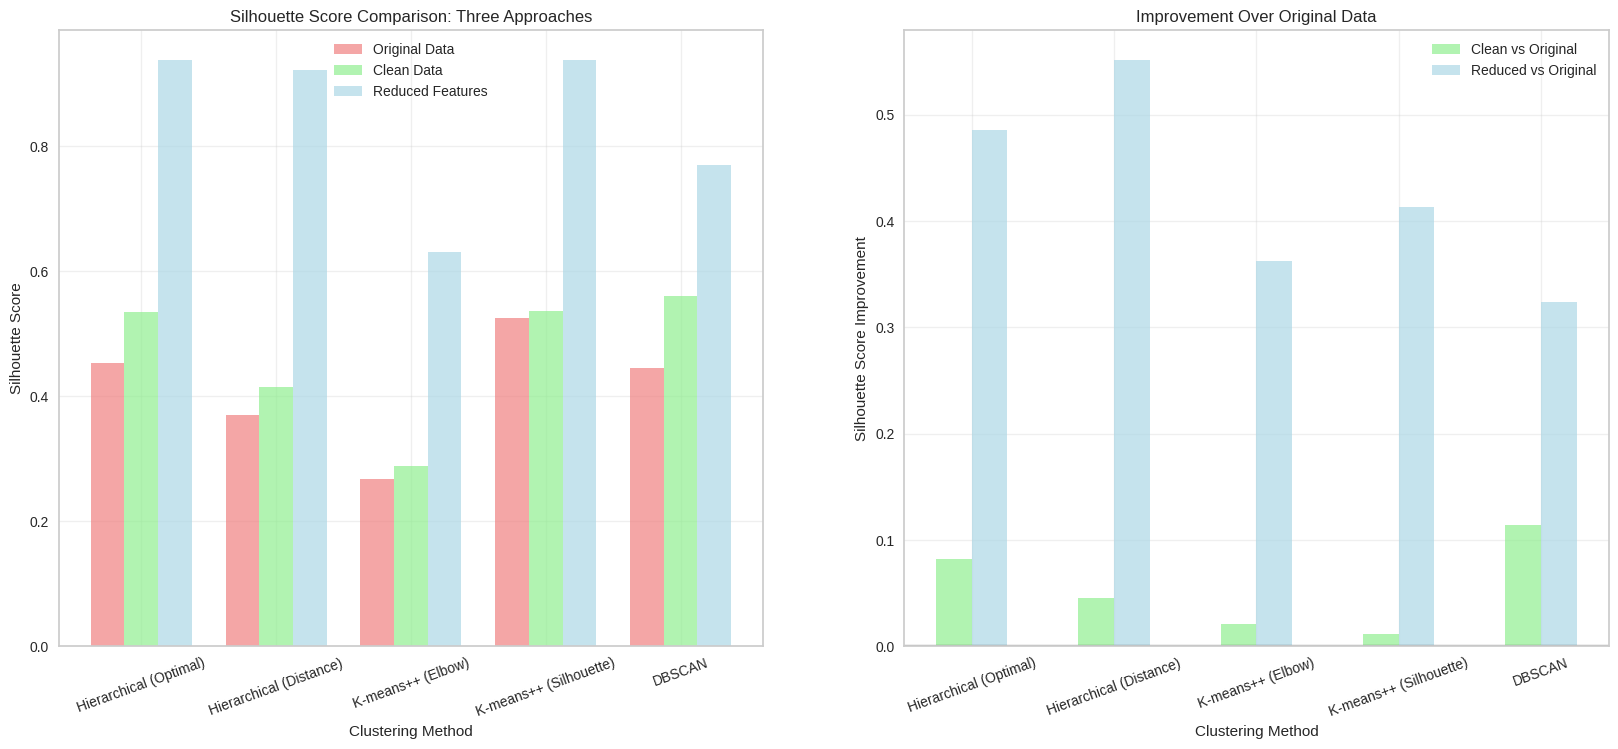

In [ ]:
# Visualize comprehensive comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Silhouette scores comparison
ax1 = axes[0]
x = np.arange(len(comparisonDFThree))
width = 0.25

bars1 = ax1.bar(x - width, comparisonDFThree['Original Data'], width, label='Original Data', color='lightcoral', alpha=0.7)
bars2 = ax1.bar(x, comparisonDFThree['Clean Data'], width, label='Clean Data', color='lightgreen', alpha=0.7)
bars3 = ax1.bar(x + width, comparisonDFThree['Reduced Features'], width, label='Reduced Features', color='lightblue', alpha=0.7)

ax1.set_xlabel('Clustering Method')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score Comparison: Three Approaches')
ax1.set_xticks(x)
ax1.set_xticklabels(comparisonDFThree['Method'], rotation=20)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Improvement over original
ax2 = axes[1]
bars4 = ax2.bar(x - width/2, comparisonDFThree['Clean vs Original'], width, label='Clean vs Original', color='lightgreen', alpha=0.7)
bars5 = ax2.bar(x + width/2, comparisonDFThree['Reduced vs Original'], width, label='Reduced vs Original', color='lightblue', alpha=0.7)

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_xlabel('Clustering Method')
ax2.set_ylabel('Silhouette Score Improvement')
ax2.set_title('Improvement Over Original Data')
ax2.set_xticks(x)
ax2.set_xticklabels(comparisonDFThree['Method'], rotation=20)
ax2.legend()
ax2.grid(True, alpha=0.3)

In [ ]:
# Summary statistics
print(f"SUMMARY STATISTICS")
print(f"Average silhouette score - Original: {comparisonDFThree['Original Data'].mean():.4f}")
print(f"Average silhouette score - Clean: {comparisonDFThree['Clean Data'].mean():.4f}")
print(f"Average silhouette score - Reduced: {comparisonDFThree['Reduced Features'].mean():.4f}")

print(f"\nAverage improvement - Clean vs Original: {comparisonDFThree['Clean vs Original'].mean():.4f}")
print(f"Average improvement - Reduced vs Original: {comparisonDFThree['Reduced vs Original'].mean():.4f}")
print(f"Average improvement - Reduced vs Clean: {comparisonDFThree['Reduced vs Clean'].mean():.4f}")

# Find best method-approach combination
bestCombination = comparisonDFThree.loc[comparisonDFThree[['Original Data', 'Clean Data', 'Reduced Features']].max(axis=1).idxmax()]
bestScoreOverall = bestCombination[['Original Data', 'Clean Data', 'Reduced Features']].max()
bestApproachOverall = ['Original Data', 'Clean Data', 'Reduced Features'][np.argmax(bestCombination[['Original Data', 'Clean Data', 'Reduced Features']].values)]

print(f"\nBest method-approach combination:")
print(f"Method: {bestCombination['Method']}")
print(f"Approach: {bestApproachOverall}")
print(f"Silhouette Score: {bestScoreOverall:.4f}")

SUMMARY STATISTICS
Average silhouette score - Original: 0.4124
Average silhouette score - Clean: 0.4674
Average silhouette score - Reduced: 0.8398

Average improvement - Clean vs Original: 0.0551
Average improvement - Reduced vs Original: 0.4275
Average improvement - Reduced vs Clean: 0.3724

Best method-approach combination:
Method: Hierarchical (Optimal)
Approach: Reduced Features
Silhouette Score: 0.9385


In [ ]:
# Additional analysis
print(f"ADDITIONAL ANALYSIS")
print(f"Dataset size - Original: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Dataset size - Clean: {XOutlier.shape[0]} samples, {XOutlier.shape[1]} features")
print(f"Dataset size - Reduced: {XReduced.shape[0]} samples, {XReduced.shape[1]} features")

print(f"\nData reduction:")
print(f"Outlier removal: {((X.shape[0] - XOutlier.shape[0]) / X.shape[0] * 100):.1f}% samples removed")
print(f"Feature selection: {((X.shape[1] - XReduced.shape[1]) / X.shape[1] * 100):.1f}% features removed")

ADDITIONAL ANALYSIS
Dataset size - Original: 1000 samples, 35 features
Dataset size - Clean: 950 samples, 35 features
Dataset size - Reduced: 1000 samples, 8 features

Data reduction:
Outlier removal: 5.0% samples removed
Feature selection: 77.1% features removed
